In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import geopandas as gpd
import random
from scipy.stats import truncnorm, norm
from collections import defaultdict
import math
from shapely.ops import transform
from pyproj import Geod
import pyarrow
from datetime import datetime
from dataclasses import dataclass
import yaml
from typing import Union

In [91]:
# Функции генерации паттернов времени и базовые функции времени созданные ранее
import data_generator.configs
from data_generator.general_time import *
from data_generator.utils import build_transaction, create_txns_df

In [5]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [3]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01\\notebooks'

In [4]:
os.chdir("..")
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01'

## Конфиги

In [38]:
# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Общие настройки фрода
with open("./config/fraud.yaml") as f:
    fraud_cfg = yaml.safe_load(f)
# Настройки compromised client фрода
with open("./config/compr.yaml") as f:
    compr_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

# Доп. данные для генерации фрод транзакций

**Загрузка данных:**
- оффлайн мерчантов
- онлайн мерчантов
- девайсов клиентов и мошенников
- городов с полигонами
- городов с координатами центров
- клиентов
- фрод IP адресов
- категорий и их характеристик
- антифрод правил и их весов

In [36]:
offline_merchants = pd.read_parquet("./data/base/offline_merchants_points.parquet")
online_merchant_ids = pd.read_csv("./data/base/online_merchant_ids.csv").iloc[:, 0]
client_devices = pd.read_csv("./data/base/client_devices.csv")
fraud_devices = pd.read_csv("./data/base_fraud/fraud_devices.csv")
cities = gpd.read_file("./data/base/cities.gpkg")
city_centers = gpd.read_file("./data/base/city_centers.gpkg")
clients = pd.read_parquet("./data/clients/clients.parquet")
cat_stats_full = pd.read_csv("./data/base/cat_stats_full.csv")
fraud_ips = pd.read_parquet("./data/base_fraud/fraud_ips.parquet")
rules_df = pd.read_csv("./data/base_fraud/rules.csv")
cat_fraud_amts = pd.read_csv("./data/base_fraud/cat_fraud_amts.csv")

# Конфигурации и данные для генерации транзакций

## `CompPurchFraudCfg` dataclass  
Датакласс для хранения конфигураций и данных для генерации транзакций.
- модуль `data_generator.configs`

In [6]:
# ------------------------ ВСТАВИТЬ КОД СЮДА ---------------------------

## Конструктор конфиг класса `ComprConfigBuilder`
- модуль `data_generator.fraud.compr.build.config`
- создает объект `CompPurchFraudCfg`

In [3]:
# ------------------------ ВСТАВИТЬ КОД СЮДА ---------------------------

### **Тест `ComprConfigBuilder`**

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Общие настройки фрода
with open("./config/fraud.yaml") as f:
    fraud_cfg = yaml.safe_load(f)
# Настройки compromised client фрода
with open("./config/compr.yaml") as f:
    compr_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

In [2]:
from data_generator.fraud.compr.build.config import ComprConfigBuilder

compr_builder = ComprConfigBuilder(base_cfg=base_cfg, time_cfg=time_cfg, \
                                  fraud_cfg=fraud_cfg, compr_cfg=compr_cfg)
configs = compr_builder.build_cfg()

# Генерация времени

**Датафрейм под транзакции. Этап тестов**<br>
Создадим пустой датафрейм под транзакции. Будем копировать и использовать его при тестах функций.

In [24]:
transactions = create_txns_df(base_cfg["txns_df"])
transactions

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule


## Подфункция генерации времени для фрод кейсов `fast_geo_change` и `fast_geo_change_online`
- модуль `data_generator.fraud.compr.time`

In [25]:
# def generate_time_fast_geo_jump(last_txn_unix, geo_distance, threshold=800):
#         """
#         Генерация времени с коротким интервалом от предыдущей транзакции, для имитации быстрой смены геопозиции
#         ---------------------------------------------------------------------
#         last_txn_unix - время последней транзакции в unix формате в секундах.
#         geo_distance - кратчайшая дистанция между точками координат последней и текущей транзакции - в километрах.
#                        Точки между координатами берутся при генерации транзакции. Домашний город клиента и любой другой город, кроме домашнего.
#         threshold - порог скорости перемещения между точками в км/ч. Все что быстрее - фрод.
#                     Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций.
#                     Быстрая скорость - маленькое время между транзакциями в плане возможностей перемещения на расстояние.
#         ---------------------------------------------------------------------
#         Возвращает pd.Timestamp и unix время в секундах.
#         """

#         # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
#         # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
#         # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
#         # но в зависимости от расстояния мы берем разные границы для распределений, чтобы не было перекоса в очень быстрое время. 
#         # Также 20 минут я случайно взял как средний интервал для подобной фрод транзакции.
#         # Конечно же "скорость перемещения" может быть и больше в реальной жизни
        
#         if geo_distance < 1000:
#             fact_speed = np.random.uniform(threshold + 1, 3000)
#         elif geo_distance >= 1000 and geo_distance <= 3000:
#             fact_speed = np.random.uniform(threshold + 1, 9000)
#         elif geo_distance > 3000 and geo_distance <= 6000:
#             fact_speed = np.random.uniform(threshold + 1, 18000)
#         else:
#             fact_speed = np.random.uniform(threshold + 1, 36000)
        
#         # Делим полученную скорость на 3.6 для перевода в м/с - для расчета времени в секундах
#         # т.к. будет добавлять к unix времени предыдущей транзакции
#         fact_speed /= 3.6

#         # переводим дистанцию в метры
#         geo_distance = geo_distance * 1000
    
#         # интервал времени между последней транзакцией и текущей фрод транзакцией в секундах
#         time_interval = geo_distance / fact_speed
        
#         txn_unix = round(last_txn_unix + time_interval)
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#         return txn_time, txn_unix

### **Тест `generate_time_fast_geo_jump`**

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Общие настройки фрода
with open("./config/fraud.yaml") as f:
    fraud_cfg = yaml.safe_load(f)
# Настройки compromised client фрода
with open("./config/compr.yaml") as f:
    compr_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

In [5]:
from data_generator.fraud.compr.build.config import ComprConfigBuilder
from data_generator.fraud.compr.time import generate_time_fast_geo_jump
from data_generator.general_time import pd_timestamp_to_unix

compr_builder = ComprConfigBuilder(base_cfg=base_cfg, time_cfg=time_cfg, \
                                  fraud_cfg=fraud_cfg, compr_cfg=compr_cfg)
configs = compr_builder.build_cfg()

In [8]:
# Тест generate_time_fast_geo_jump()
# Каждую дистанцию повторим 10 раз в колонке distance. Чтобы было больше попыток генерации
distances = pd.DataFrame({"distance":[800]*10 + [1200]*10 + [5000]*10 + [7500]*10})
distances["minutes"] = 0
last_time = pd.to_datetime("2023-09-20 09:14:00", format="%Y-%m-%d %H:%M:%S")
last_unix = pd_timestamp_to_unix(last_time)
distances["last_unix"] = last_unix


for row in distances.itertuples():
    _, txn_unix = generate_time_fast_geo_jump(last_txn_unix=last_unix, geo_distance=row.distance, threshold=800)
    distances.loc[row.Index, "txn_unix"] = txn_unix
    
distances["time_diff"] = (distances["txn_unix"] - distances["last_unix"]) // 60

distances.groupby("distance").time_diff.mean()

distance
800     26.8
1200    15.2
5000    49.2
7500    70.0
Name: time_diff, dtype: float64

In [60]:
# for dist in list(np.arange(0, 9000, 0.1)):
#     generate_time_fast_geo_jump(last_txn_unix=last_unix, geo_distance=dist, threshold=800)


## Подфункция генерации времени транзакции для правила `trans_freq_increase`
- модуль `data_generator.fraud.compr.time`
- несколько частых транзакций подряд

In [26]:
# def gen_time_for_frequent_trans(last_txn_time, last_txn_unix, freq_low=1, freq_high=5, test=False):
#     """
#     Функция для имитации времени нескольких частых транзакций подряд.
#     -------------------------------------------------
#     last_txn_time - pd.Timestamp последней транзакции
#     last_txn_unix - unix время последней транзакции в секундах
#     freq_low - int. минимальный разрыв между транзакциями в цепочке транзакций, в минутах
#     freq_high - int. максимальный разрыв между транзакциями в цепочке транзакций, в минутах
#     test - True или False. Тестируем мы функцию или нет.
#     --------------------------------------------------
#     При test == False возвращает pd.Timestamp и unix time в секундах
#     При test == True возвращает pd.Timestamp, unix time в секундах и получившуюся разницу времени
#     с предыдущей транзакцией в минутах в виде int
#     """

    
#     # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства расчетов
#     freq = random.randint(freq_low, freq_high) * 60
#     txn_unix = last_txn_unix + freq
#     txn_time = pd.to_datetime(txn_unix, unit="s")

#     if not test:
#         return txn_time, txn_unix
    
#     else:
#         return txn_time, txn_unix, freq

**Тест `gen_time_for_frequent_trans` в цикле**

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Общие настройки фрода
with open("./config/fraud.yaml") as f:
    fraud_cfg = yaml.safe_load(f)
# Настройки compromised client фрода
with open("./config/compr.yaml") as f:
    compr_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

In [2]:
from data_generator.fraud.compr.build.config import ComprConfigBuilder
from data_generator.fraud.compr.time import gen_time_for_frequent_trans
from data_generator.general_time import pd_timestamp_to_unix
from data_generator.utils import create_txns_df

compr_builder = ComprConfigBuilder(base_cfg=base_cfg, time_cfg=time_cfg, \
                                  fraud_cfg=fraud_cfg, compr_cfg=compr_cfg)
configs = compr_builder.build_cfg()
transactions = create_txns_df(base_cfg["txns_df"])

In [3]:
# Датафрейм с последней транзакцией - перезапустить ячейку для теста ниже
last_time = pd.to_datetime("2023-09-20 09:14:00", format="%Y-%m-%d %H:%M:%S")
last_unix = pd_timestamp_to_unix(last_time)

trans_test_freq_time = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account', 'is_fraud', 'is_suspicious']]
trans_test_freq_time.loc[0, ["txn_time","unix_time"]] = last_time, last_unix
print(f"last_time, last_unix: {last_time, last_unix}")
trans_test_freq_time

last_time, last_unix: (Timestamp('2023-09-20 09:14:00'), 1695201240)


,txn_time,unix_time,online,account,is_fraud,is_suspicious
0,2023-09-20 09:14:00,1.695201e+09,NaN,NaN,NaN,NaN


In [5]:
trans_freq_temp_df = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account', 'is_fraud', 'is_suspicious']]
last_time = trans_test_freq_time.at[trans_test_freq_time.unix_time.idxmax(), "txn_time"]
last_unix = pd_timestamp_to_unix(last_time)
freq_values = []


for i in range(1,11):
    txn_time, txn_unix, freq = gen_time_for_frequent_trans(last_txn_unix=last_unix, configs=configs, test=True)
    freq_values.append(freq / 60)
        
    trans_freq_temp_df.loc[i, "txn_time"] = txn_time
    trans_freq_temp_df.loc[i, "unix_time"] = txn_unix
    trans_freq_temp_df.loc[i, "is_fraud"] = True

    
    last_time = txn_time
    last_unix = txn_unix

# средняя частота фрод транзакций - всех, кроме первой фрод транзакции
print("\n\n Mean freq: ",pd.Series(freq_values).mean(), " minutes\n\n")

# к последней легальной транзакции присоединяем сгенерированные частые транзакции
trans_test_freq_time = pd.concat([trans_test_freq_time, trans_freq_temp_df])
# разница во времени с предыдущей транзакцией, в минутах
trans_test_freq_time["time_diff"] = trans_test_freq_time.unix_time.sub(trans_test_freq_time.unix_time.shift(1)) / 60
trans_test_freq_time



 Mean freq:  3.0  minutes




,txn_time,unix_time,online,account,is_fraud,is_suspicious,time_diff
0,2023-09-20 09:14:00,1.695201e+09,NaN,NaN,NaN,NaN,NaN
1,2023-09-20 09:18:00,1.695201e+09,NaN,NaN,True,NaN,4.0
2,2023-09-20 09:21:00,1.695202e+09,NaN,NaN,True,NaN,3.0
3,2023-09-20 09:24:00,1.695202e+09,NaN,NaN,True,NaN,3.0
4,2023-09-20 09:29:00,1.695202e+09,NaN,NaN,True,NaN,5.0
5,2023-09-20 09:34:00,1.695202e+09,NaN,NaN,True,NaN,5.0
1,2023-09-20 09:39:00,1.695203e+09,NaN,NaN,True,NaN,5.0
2,2023-09-20 09:43:00,1.695203e+09,NaN,NaN,True,NaN,4.0
3,2023-09-20 09:45:00,1.695203e+09,NaN,NaN,True,NaN,2.0
4,2023-09-20 09:46:00,1.695203e+09,NaN,NaN,True,NaN,1.0


**Функция получения случайных значений из `truncnorm` распределения**
- пойдет в модуль `utils`

In [33]:
def get_values_from_truncnorm(low_bound, high_bound, mean, std, size=1):
    """
    Сгенерировать массив чисел из обрезанного нормального распределения.
    Можно сгенерировать массив с одним числом
    ------------
    low_bound - float, int. Нижняя граница значений
    high_bound - float, int. Верхняя граница значений 
    mean - float, int. Среднее
    std - float, int. Стандартное отклонение
    size - Количество чисел в возвращаемом массиве
    ------------
    Возвращает np.ndarray
    """
    return truncnorm.rvs((low_bound - mean) / std, (high_bound - mean) / std, loc=mean, scale=std, size=size)

## Подфункция `derive_from_last_time`  
- модуль `data_generator.fraud.time`
- генерация времени через прибавление ко времени последней транзакции 

In [445]:
# def derive_from_last_time(last_txn_unix, lag_interval, min=0, max=0, random_lag=False, geo_distance=0, threshold=800):
#     """
#     Создать время основываясь на времени последней транзакции.
#     Либо на основании гео дистанции между транзакциями либо на основании заданного лага по времени.
#     Для гео надо ввести geo_distance. Для лага, НЕ вводить geo_distance, ввести lag_interval
#     ---------------
#     last_txn_unix - int. Unix время последней транзакции в секундах.
#     lag_interval - int. Желаемый лаг по времени от последней транзакции в минутах.
#     min - int. Минуты. Минимальное значение если нужен случайный лаг по времени. Выставляется когда random_lag - True
#     max - int. Минуты. Максимальное значение если нужен случайный лаг по времени. Не включается в возможные выбор, ставить на 1 больше.
#                Выставляется когда random_lag - True
#     random_lag - bool. Должно ли значение лага быть случайным. Берется по равномерному распределению.
#     geo_distance - int. Расстояние между координатами текущей и последней транзакции в километрах.
#     threshold - int. Максимальная допустимая скорость перемещения км/ч между совершением транзакций,
#                      для случаев когда расстояние больше 500 километров.
#     ---------------
#     Возвращает unix время в секундах
#     """
#     # Перевод в секунды для расчетов
#     lag_interval = lag_interval * 60

#     if random_lag:
#         lag_interval = np.random.randint(min, max) * 60

#     if geo_distance == 0:
#         txn_unix = last_txn_unix + lag_interval
#         txn_time = pd.to_datetime(txn_unix, unit="s")
#         return txn_time, txn_unix
    
#     if geo_distance <= 500:
#         mean = 90
#         std = 20
#         speed = get_values_from_truncnorm(low_bound=50, high_bound=120, mean=mean, std=std).astype("int")[0]
#         # Расчет добавления времени и перевод в секунды
#         lag_interval = round((geo_distance / speed) * 3600)

#     elif geo_distance > 500:
#         mean = 300
#         std = 200
#         speed = get_values_from_truncnorm(low_bound=50, high_bound=threshold, mean=mean, std=std).astype("int")[0]
#         # Расчет добавления времени и перевод в секунды
#         lag_interval = round((geo_distance / speed) * 3600)

#     txn_unix = last_txn_unix + lag_interval
#     txn_time = pd.to_datetime(txn_unix, unit="s")
        
#     return txn_time, txn_unix

In [211]:
derive_last = pd_timestamp_to_unix(pd.to_datetime("2025-06-20 11:57:12", format="%Y-%m-%d %H:%M:%S"))
derive_last
# pd.to_datetime(derive_last, unit="s")

1750420632

In [214]:
derive_from_last_time(last_txn_unix=derive_last, lag_interval=0, min=30, max=60, random_lag=True)

(Timestamp('2025-06-20 12:43:12'), 1750423392)

## Функция `get_time_fraud_txn`
- модуль `data_generator.fraud.compr.time`
- конечная функция генерации времени для compomised фрода

In [215]:
# def get_time_fraud_txn(trans_df, time_weights, timestamps, round_clock, online=None, \
#                            rule=None, geo_distance=None, lag=None, threshold=800):
#     """
#     Создать время для генерируемой фрод транзакции
#     ---------------------------------------
#     trans_df - датафрейм с транзакциями текущего клиента. Откуда брать информацию по предыдущим транзакциям клиента
#     time_weights - датафрейм с весами часов в периоде времени
#     timestamps - датафрейм с timestamps
#     round_clock - boolean. Круглосуточная или дневная категория.
#     online - boolean. Онлайн или оффлайн покупка. True or False
#     rule - str. Название антифрод правила
#     geo_distance - int. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в километрах
#     lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
#           Это задержка именно между последней легитимной транзакцией и серией частых фрод транзакций. Подразумевается что функция
#           get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.
#     threshold - int. Максимальная скорость перемещения между совершением транзакций км/ч.
#                      Фрод с быстрой сменой гео будет превышать этот порог.
#     ---------------------------------------------
#     Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
#     """
    
#     # Время последней транзакции клиента. pd.Timestamp и unix в секундах
#     last_txn_time = trans_df.txn_time.max()
#     last_txn_unix = trans_df.unix_time.max()

#     # Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
#     if rule in ["fast_geo_change", "fast_geo_change_online"]:
#         return generate_time_fast_geo_jump(last_txn_unix=last_txn_unix, geo_distance=geo_distance, threshold=threshold)
    
#     # Если это не первая фрод транзакция в серии частых транзакций для правила trans_freq_increase
#     # Для первой транзакции в серии (lag==True) время будет создано прибавлением интервала к последней транзакции клиента
#     elif rule == "trans_freq_increase" and not lag:
#         return gen_time_for_frequent_trans(last_txn_time=last_txn_time, last_txn_unix=last_txn_unix, freq_low=1, freq_high=5)
    
#     # Генерация времени на основе времени предыдущей транзакции, но с учетом гео.
#     # Обеспечивает НЕпопадание под правила резкой смены гео.
#     elif rule in ["new_ip_and_device_high_amount", "new_device_and_high_amount", "trans_freq_increase"]:
#         # Случайный lag_interval от 30 до 60 минут для случаев где дистанция 0
#         return derive_from_last_time(last_txn_unix=last_txn_unix, lag_interval=0, min=30, max=60, \
#                                      random_lag=True, geo_distance=geo_distance, threshold=threshold)
        
#     # Время для остальных правил. Просто семплирование времени в соответсвии с весами
#     # берем случайный час передав веса часов для соответсвующейго временного паттерна
#     txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
    
#     # фильтруем по этому часу timestamp-ы и семплируем timestamp уже с равной вероятностью
#     # Дальше будем обрабатывать этот timestamp в некоторых случаях
#     timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#     timestamp_sample = timestamps_subset.sample(n=1, replace=True)
#     txn_time = timestamp_sample.timestamp.iloc[0]
    
#     return txn_time, pd_timestamp_to_unix(txn_time)

## Объект класса `CompPurchFraudCfg`
- конфигурации и данные для генерации транзакций

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Общие настройки фрода
with open("./config/fraud.yaml") as f:
    fraud_cfg = yaml.safe_load(f)
# Настройки compromised client фрода
with open("./config/compr.yaml") as f:
    compr_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

In [2]:
from data_generator.fraud.compr.build.config import ComprConfigBuilder

compr_builder = ComprConfigBuilder(base_cfg=base_cfg, time_cfg=time_cfg, \
                                  fraud_cfg=fraud_cfg, compr_cfg=compr_cfg)
configs = compr_builder.build_cfg()

# Генерация одной фрод транзакции

**Функция семплирования правила `sample_rule`**
- модуль `data_generator.utils`

In [3]:
# Функция семплирования правила

def sample_rule(rules):
    """
    rules - pd.DataFrame с названиями правил и их весами
    """
    return rules.rule.sample(1, weights=rules.weight).iat[0]

In [6]:
sample_rule(configs.rules)

'fast_geo_change'

**Функция `sample_category`**  
На данный момент предназначена только для фрода

In [7]:
def sample_category(categories, online=None, is_fraud=None, rule=None):
    """
    categories - pd.DataFrame с категориями и их характеристиками
    online - bool. Онлайн или оффлайн категория нужна
    is_fraud - bool. Фрод или не фрод. От этого зависит вероятность категории.
    """

    if is_fraud and online and rule != "trans_freq_increase":
        online_categories = categories.loc[categories.online == True]
        cat_sample = online_categories.sample(1, weights=online_categories.fraud_share)
        return cat_sample

    elif is_fraud and online and rule == "trans_freq_increase":
        chosen_categories = categories.loc[categories.category.isin(["shopping_net", "misc_net"])]
        cat_sample = chosen_categories.sample(1, weights=chosen_categories.fraud_share)
        return cat_sample

        
    elif is_fraud and not online:
        offline_categories = categories.loc[categories.online == False]
        cat_sample = offline_categories.sample(1, weights=offline_categories.fraud_share)
        return cat_sample
        

In [83]:
# cat_stats_full.loc[cat_stats_full.category.isin(["shopping_net", "misc_net"])]

In [9]:
sample_category(configs.categories, online=True, is_fraud=True, rule="trans_freq_increase")

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
11,misc_net,1179.003552,2454.586333,27367,True,0.049246,267,0.009756,True


## Класс `FraudTxnPartData` - генерация части данных транзакции
-  локация, мерчант id, ip адрес, device id, канал, тип транзакции. Для некоторых правил еще статус.
-  не генерирует время.

In [111]:
# class FraudTxnPartData:
#     """
#     Класс для генерации данных о транзакции для фрода в покупках
#     когда данные/аккаунт клиента скомпрометированы: 
#     канал, тип операции, мерчант, геопозиция, город, IP адрес, иногда статус.
#     ------------------
#     Атрибуты:
#     --------
#     merchants_df - pd.DataFrame. Оффлайн мерчанты
#     client_info - pd.DataFrame или namedtuple. Запись с информацией о клиенте
#     online_merchant_ids- pd.Series. id онлайн мерчантов
#     fraud_ips - pd.DataFrame. ip для фрода с гео информацией
#     used_ips - pd.Series. Сюда записывать ip адреса использованные для фрода.
#     fraud_devices - pd.DataFrame. девайсы для фрода: платформа, id устройства.
#     used_devices - pd.Series. Сюда записывать id девайсов использованные для фрода.
#     client_devices - pd.DataFrame. Девайсы клиентов.
#     last_txn - tuple. Предыдущая транзакция. Записывается при использовании некоторых методов (пока только для freq_trans)
#     """
#     def __init__(self, configs: CompPurchFraudCfg):
#         """
#         configs: CompPurchFraudCfg. Содержит параметры и конфиги для генерации фрода.
#         """
#         self.merchants_df = configs.offline_merchants
#         self.client_info = None
#         self.online_merchant_ids = configs.online_merchant_ids
#         self.fraud_ips = configs.fraud_ips
#         self.used_ips = pd.Series(name="ip_address")
#         self.fraud_devices = configs.fraud_devices
#         self.client_devices = configs.client_devices
#         self.used_devices = pd.Series(name="device_id")
#         self.last_txn = None
    
#     def another_city(self, client_city, online, category_name):
#         """
#         Генерация merchant_id, координат транзакции, названия города, IP адреса и device_id (если онлайн)
#         C городом отличным от города клиента. Для онлайн транзакций также другой device_id и IP адрес в другом городе.
#         Нужен для правил: fast_geo_change, fast_geo_change_online, new_ip_and_device_high_amount.
#         -----------------------------------------------
#         Работает для онлайн и оффлайн транзакций
#         client_city - str.
#         online - bool.
#         category_name - str.
#         """
        
#         if online:
#             merchant_id = self.online_merchant_ids.sample(n=1).iat[0]
            
#             # Семпл IP которого нет в used_ips и который IP другого города
#             fraud_ips = self.fraud_ips.loc[~self.fraud_ips.fraud_ip.isin(self.used_ips)]
#             fraud_ip = fraud_ips.loc[fraud_ips["area"] != client_city].sample(1)
#             # Координаты города и название по IP адресу
#             trans_lat = fraud_ip.lat.iloc[0]
#             trans_lon = fraud_ip.lon.iloc[0]
#             trans_ip = fraud_ip.fraud_ip.iloc[0]
#             trans_city = fraud_ip["area"].iloc[0]
#             channel = "ecom"
            
#             # Семпл девайса которого нет в used_devices
#             devices = self.fraud_devices.loc[~self.fraud_devices.device_id.isin(self.used_devices), "device_id"]
#             device_id = devices.sample(1).iloc[0]
            
#             # Записываем IP и device_id как использованные
#             self.used_ips.loc[self.used_ips.shape[0]] = trans_ip
#             self.used_devices.loc[self.used_devices.shape[0]] = device_id

#         else:
#             # Семплируется мерчант не из города клиента
#             merchants = self.merchants_df.loc[self.merchants_df["area"] != client_city]
#             merchant = merchants.loc[merchants.category == category_name].sample(1)
#             # Берется его id, и координаты, как координаты транзакции
#             merchant_id = merchant["merchant_id"].iloc[0]
#             trans_lat = merchant["merchant_lat"].iloc[0]
#             trans_lon = merchant["merchant_lon"].iloc[0]
#             trans_ip = "not applicable"
#             trans_city = merchant["area"].iloc[0]
#             device_id = np.nan
#             channel = "POS"

        
#         txn_type = "purchase"
            
#         return merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, txn_type


#     def new_device_and_ip(self, client_city, category_name, online=True, another_city=True):
#         """
#         Генерация merchant_id, координат транзакции, названия города, IP адреса(если применимо) и device_id
#         Для правил: new_ip_and_device_high_amount, new_device_and_high_amount, freq_trans.
#         ---------------------------------------------------------------------
#         another_city - bool. Должен ли IP быть отличного от клиентского города.
#         """
#         merchant_id = self.online_merchant_ids.sample(n=1).iat[0]

#         # IP адрес другого города и остальная информация
#         if another_city:
#             return self.another_city(client_city=client_city, online=online, category_name=category_name)
            
#         # Другой IP адрес, но город клиента - для new_device_and_high_amount
#         fraud_ips = self.fraud_ips.loc[~self.fraud_ips.fraud_ip.isin(self.used_ips)]
#         fraud_ip = fraud_ips.loc[fraud_ips["area"] == client_city].sample(1)
        
#         # Координаты города и название по IP адресу
#         trans_lat = fraud_ip.lat.iloc[0]
#         trans_lon = fraud_ip.lon.iloc[0]
#         trans_ip = fraud_ip.fraud_ip.iloc[0]
#         trans_city = fraud_ip["area"].iloc[0]

#         # Записываем IP как использованный
#         self.used_ips.loc[self.used_ips.shape[0]] = trans_ip
        
#         # Семпл девайса которого нет в used_devices
#         devices = self.fraud_devices.loc[~self.fraud_devices.device_id.isin(self.used_devices), "device_id"]
#         device_id = devices.sample(1).iloc[0]
        
#         # Записываем device_id как использованный
#         self.used_devices.loc[self.used_devices.shape[0]] = device_id

#         channel = "ecom"
#         txn_type = "purchase"
        
#         return merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, txn_type


#     def freq_trans(self, client_city, category_name, another_city):
#         """
#         another_city - bool. Должен ли IP быть отличного от клиентского города.
#         """
#         self.last_txn = self.new_device_and_ip(client_city, category_name, online=True, another_city=another_city)
        
#         return self.last_txn


#     def reset_used(self, used_ips=False, used_devices=False):
#         """
#         Сброс кэша использованных ip и/или девайсов
#         Можно выбрать одно или оба сразу.
#         ----------
#         used_ips - bool
#         used_devices - bool
#         """

#         if used_ips:
#             self.used_ips = pd.Series(name="ip_address")
            
#         if used_devices:
#             self.used_devices = pd.Series(name="device_id")

### **Тест `FraudTxnPartData`**

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Общие настройки фрода
with open("./config/fraud.yaml") as f:
    fraud_cfg = yaml.safe_load(f)
# Настройки compromised client фрода
with open("./config/compr.yaml") as f:
    compr_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

clients = pd.read_parquet("./data/clients/clients.parquet")

In [2]:
from data_generator.fraud.compr.build.config import ComprConfigBuilder
from data_generator.fraud.compr.txndata import FraudTxnPartData

compr_builder = ComprConfigBuilder(base_cfg=base_cfg, time_cfg=time_cfg, \
                                  fraud_cfg=fraud_cfg, compr_cfg=compr_cfg)
configs = compr_builder.build_cfg()

part_data = FraudTxnPartData(configs=configs)

In [3]:
for client_info in clients.loc[[1]].itertuples():
    part_data.client_info = client_info
part_data.client_info

Pandas(Index=1, client_id=2, city_id=1, birth_date=Timestamp('1970-01-29 00:00:00'), sex='male', region='Москва', city='Москва', timezone='UTC+3', lat=55.7538789, lon=37.6203735, population=11514330, home_ip='2.60.0.2')

In [4]:
part_data.freq_trans(category_name="shopping_net", another_city=False)

(np.int64(6822),
 np.float64(55.7538789),
 np.float64(37.6203735),
 '5.8.29.151',
 'Москва',
 np.int64(12417),
 'ecom',
 'purchase')

In [5]:
part_data.last_txn

(np.int64(6822),
 np.float64(55.7538789),
 np.float64(37.6203735),
 '5.8.29.151',
 'Москва',
 np.int64(12417),
 'ecom',
 'purchase')

In [6]:
part_data.another_city(online=True, category_name="shopping_net")

(np.int64(6973),
 np.float64(53.7942757),
 np.float64(87.2144046),
 '5.8.16.63',
 'Новокузнецк',
 np.int64(13552),
 'ecom',
 'purchase')

In [7]:
part_data.new_device_and_ip(category_name="shopping_net")

(np.int64(6837),
 np.float64(56.009466),
 np.float64(92.8524162),
 '5.8.5.167',
 'Красноярск',
 np.int64(13266),
 'ecom',
 'purchase')

In [8]:
part_data.new_device_and_ip(category_name="shopping_net", another_city=False)

(np.int64(6839),
 np.float64(55.7538789),
 np.float64(37.6203735),
 '5.8.10.29',
 'Москва',
 np.int64(13341),
 'ecom',
 'purchase')

In [9]:
part_data.another_city(online=False, category_name="shopping_pos")

(np.float64(224.0),
 np.float64(54.27792282322854),
 np.float64(48.2908740738249),
 'not applicable',
 'Ульяновск',
 nan,
 'POS',
 'purchase')

In [10]:
part_data.used_devices

0    12417
1    13552
2    13266
3    13341
Name: device_id, dtype: int64

In [11]:
part_data.used_ips

0    5.8.29.151
1     5.8.16.63
2     5.8.5.167
3     5.8.10.29
Name: ip_address, dtype: object

In [12]:
part_data.reset_used(used_ips=True, used_devices=True)

In [14]:
part_data.used_ips

Series([], Name: ip_address, dtype: object)

In [15]:
part_data.used_devices

Series([], Name: device_id, dtype: object)

## Функция расчета расстояния между координатами  
- будет добавлена в `utils`

In [143]:
def calc_distance(lat_01, lon_01, lat_02, lon_02, km=True):
    """
    Считает растояние между двумя координатами на Земном шаре.
    Между координатами последней по времени транзакции и переданными координатами.
    -----------------------------
    lat_01 - float. Широта первой точки
    lon_01 - float. Долгота первой точки
    lat_02 - float. Широта второй точки
    lon_02 - float. Долгота второй точки
    km - bool. Единицы измерения. Либо километры либо метры. Километры округляет до 2-х знаков, метры до целого.
    """
    
    # Геодезический расчёт по эллипсоиду WGS84
    geod = Geod(ellps="WGS84")
    # [-1] берет последний элемент из кортежа. Это метры
    distance_m = geod.inv(lon_01, lat_01, lon_02, lat_02)[-1]

    if km:
        return round(distance_m / 1000, 2)

    return round(distance_m)

In [144]:
# Две координаты: (долгота, широта)
coord1 = (37.617698, 55.755864)   # Москва
coord2 = (131.885494, 43.115542)   # Владивосток 6434 km - Линейка Яндекс

In [145]:
calc_distance(lat_01=55.755864, lon_01=37.617698, lat_02=43.115542, lon_02=131.885494, km=False)

6433940

## Класс `TransAmount`

In [146]:
# class TransAmount: 
#     """
#     Генерация суммы транзакции
#     """

#     def __init__(self, categories_stats):
#         """
#         categories_stats - pd.DataFrame с категориями и характеристиками их сумм
#         """
#         self.categories = categories_stats
        

#     def fraud_amount(self, category_name):
#         """
#         Фрод транзакции. Генерация суммы с выставленными минимумом, максимумом, средним и отклонением
#         """
        
#         category = self.categories[self.categories.category == category_name]
#         extreme_amount = category.extreme_amount.iloc[0]
#         low = category.fraud_low
#         high = category.fraud_high
#         mean = category.fraud_mean
#         std = category.fraud_std

#         # Генерация числа и округление до десятков
#         return get_values_from_truncnorm(low_bound=low, high_bound=high, mean=mean, std=std)[0] // 10 * 10

#     def freq_trans_amount(self, low=2000, high=10000, mean=4000, std=1500):
#         """
#         Генерация суммы специально для правила freq_trans_amount
#         """
        
#         # Генерация числа и округление до десятков
#         return get_values_from_truncnorm(low_bound=low, high_bound=high, mean=mean, std=std)[0] // 10 * 10    

### **Тест `TransAmount`**

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Общие настройки фрода
with open("./config/fraud.yaml") as f:
    fraud_cfg = yaml.safe_load(f)
# Настройки compromised client фрода
with open("./config/compr.yaml") as f:
    compr_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

In [2]:
from data_generator.fraud.compr.build.config import ComprConfigBuilder
from data_generator.fraud.compr.txndata import TransAmount

compr_builder = ComprConfigBuilder(base_cfg=base_cfg, time_cfg=time_cfg, \
                                  fraud_cfg=fraud_cfg, compr_cfg=compr_cfg)
configs = compr_builder.build_cfg()
compr_amt = TransAmount(configs=configs)

In [3]:
# pd.read_csv("./data/base_fraud/cat_fraud_amts.csv")

In [4]:
compr_amt.fraud_amount(category_name="shopping_net")

np.float64(34000.0)

In [8]:
freq_amts = [compr_amt.freq_trans_amount() for _ in range(500)]
freq_amts = pd.Series(freq_amts)
freq_amts.agg(["min","mean","max"])

min     2010.00
mean    4343.96
max     8610.00
dtype: float64

## Функция генерации одной фрод транзакции с типом "purchase" `gen_purchase_fraud_txn`

In [129]:
# def gen_purchase_fraud_txn(rule, client_info, client_trans_df, configs: CompPurchFraudCfg, trans_partial_data: FraudTxnPartData, \
#                        fraud_amts: TransAmount, all_time_weights, trans_num=0, lag=False):
#     """
#     Генерация одной фрод транзакции для клиента
#     ------------------------------------------------
#     rule - str.
#     client_info - namedtuple, полученная в результате итерации с помощью .itertuples() через датафрейм с информацией о клиентах
#     client_trans_df - датафрейм с транзакциями клиента.
#     configs - CompPurchFraudCfg dataclass. 
#     client_device_ids - pd.Series. id девайсов клиента.
#     trans_partial_data - FraudTxnPartData class.
#     fraud_amts - TransAmount class.
#     all_time_weights - dict. Датафреймы с весами времени для всех временных паттернов.
#     trans_num - int. Какая по счету транзакция в данном фрод кейсе.
#     lag - bool. Нужен ли лаг по времени от последней легальной транзакции. Используется для trans_freq_increase
#     -------------------------------------------------
#     Возвращает словарь с готовой транзакцией
#     """

#     is_fraud = True
    
#     # Запись о последней транзакции клиента
#     last_txn = client_trans_df.loc[client_trans_df.unix_time == client_trans_df.unix_time.max()]
    
#     # Записываем данные клиента в переменные
#     client_id = client_info.client_id

#     # Берем значение online флага для выбранного правила
#     online = configs.rules.loc[configs.rules.rule == rule, "online"].iat[0]
    
#     # Семплирование категории. У категорий свой вес в разрезе вероятности быть фродом
#     category = sample_category(configs.categories, online=online, is_fraud=is_fraud)
    
#     category_name = category["category"].iat[0]
#     round_clock = category["round_clock"].iat[0]
    
#     # Генерация суммы транзакции. 
#     # Пока что для всех правил кроме trans_freq_increase генерация через один и тот же метод
#     if rule == "trans_freq_increase":
#         amount = fraud_amts.freq_trans_amount(low=2000, high=10000, mean=4000, std=1500)
#     else:
#         amount = fraud_amts.fraud_amount(category_name=category_name)
    

#     # Данные о мерчанте, геопозиции, IP, девайсе
#     # Правило: быстрая смена гео. Оффлайн/онлайн
#     if rule in ["fast_geo_change", "fast_geo_change_online"]:
#         merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
#             trans_partial_data.another_city(client_city=client_info.area, online=online, category_name=category_name)

#     elif rule in ["new_ip_and_device_high_amount"]:
#         merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
#             trans_partial_data.new_device_and_ip(client_city=client_info.area, online=online, \
#                                             category_name=category_name, another_city=True)

#     elif rule == "new_device_and_high_amount":
#         merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
#             trans_partial_data.new_device_and_ip(client_city=client_info.area, online=online, \
#                                             category_name=category_name, another_city=False)

#     # Если это первая транзакция под правило trans_freq_increase
#     # То вызываем метод freq_trans для генерации части данных транзакции
#     # Они не изменятся в дальнейших транзакциях из серии. И поэтому в следующих транзакциях
#     # Будем брать кэшированный результат записанный в trans_partial_data.last_txn
#     elif rule == "trans_freq_increase" and trans_num == 1:
#         # В данном случае получаем также и статус транзакции кроме остальных данных.
#         # Зависит от того, какая это транзакция по счету из серии частых транзакций
#         merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
#             trans_partial_data.freq_trans(client_city=client_info.area, \
#                                             category_name=category_name, another_city=True)

#     # Транзакция не первая в серии. Берем кэшированные данные созданные для первой транзакции.
#     elif rule == "trans_freq_increase":
#         merchant_id, trans_lat, trans_lon, trans_ip, trans_city, device_id, channel, type = \
#             trans_partial_data.last_txn


#     # Физическое расстояние между координатами последней транзакции и координатами текущей.
#     # geo_distance = calc_distance(client_trans_df=client_trans_df, trans_lat=trans_lat, trans_lon=trans_lon)
#     geo_distance = calc_distance(lat_01=last_txn.trans_lat.iat[0], lon_01=last_txn.trans_lon.iat[0], \
#                                  lat_02=trans_lat, lon_02=trans_lon)
    
#     # 1. Offline_24h_Fraud - круглосуточные оффлайн покупки
#     if not online and round_clock:
#         weights_key = "Offline_24h_Fraud"
        
#     # 2. Online_Fraud - Онлайн покупки
#     elif online:
#         weights_key = "Online_Fraud"
        
#     # 3. Offline_Day_Fraud - Оффлайн покупки. Дневные категории.
#     elif not online and not round_clock:
#         weights_key = "Offline_Day_Fraud"
    
    
#     time_weights = all_time_weights[weights_key]["weights"]
    
#     # Генерация времени транзакции
#     txn_time, txn_unix = get_time_fraud_txn(trans_df=client_trans_df, time_weights=time_weights, timestamps=configs.timestamps, \
#                                             round_clock=round_clock, online=online, rule=rule, geo_distance=geo_distance, lag=lag)
    
    
#     # Только для freq_trans статус может отличаться от declined.
#     if rule == "trans_freq_increase" and (trans_num > 0 and trans_num < 4):
#         status = "approved"
#     else:
#         status = "declined"
        
#     # Статичные значения для данной функции
#     is_suspicious = False
#     account = pd.NA
    
#     # Возвращаем словарь со всеми данными сгенерированной транзакции
#     return build_transaction(client_id=client_id, txn_time=txn_time, txn_unix=txn_unix, amount=amount, type=type, channel=channel, \
#                              category_name=category_name, online=online, merchant_id=merchant_id, trans_city=trans_city, \
#                              trans_lat=trans_lat, trans_lon=trans_lon, trans_ip=trans_ip, device_id=device_id, account=account, \
#                              is_fraud=is_fraud, is_suspicious=is_suspicious, status=status, rule=rule)

NameError: name 'TransAmount' is not defined

### **Тест `gen_purchase_fraud_txn`**

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Общие настройки фрода
with open("./config/fraud.yaml") as f:
    fraud_cfg = yaml.safe_load(f)
# Настройки compromised client фрода
with open("./config/compr.yaml") as f:
    compr_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

In [2]:
clients_sample = pd.read_parquet("./data/clients/clients_sample.parquet")

from data_generator.fraud.compr.build.config import ComprConfigBuilder
from data_generator.fraud.compr.txndata import FraudTxnPartData, TransAmount
from data_generator.fraud.compr.txns import gen_purchase_fraud_txn
from data_generator.utils import create_txns_df, calc_distance

transactions = create_txns_df(base_cfg["txns_df"])
compr_builder = ComprConfigBuilder(base_cfg=base_cfg, time_cfg=time_cfg, \
                                  fraud_cfg=fraud_cfg, compr_cfg=compr_cfg)
configs = compr_builder.build_cfg()
part_data = FraudTxnPartData(configs)
txn_amt = TransAmount(configs)

for client in clients_sample.loc[[1]].itertuples():
    client_info = client
client_id = client_info.client_id

client_txns_df = configs.transactions.query("client_id == @client_id")
part_data.client_info = client_info
client_info

Pandas(Index=1, client_id=445, city_id=1, birth_date=Timestamp('1972-04-20 00:00:00'), sex='female', region='Москва', city='Москва', timezone='UTC+3', lat=55.7538789, lon=37.6203735, population=11514330, home_ip='2.60.1.169')

**Одиночные транзакции**

In [28]:
configs.rules

,rule,weight,online
0,fast_geo_change,0.12500,False
1,fast_geo_change_online,0.21875,True
2,new_ip_and_device_high_amount,0.25000,True
3,new_device_and_high_amount,0.18750,True
4,trans_freq_increase,0.21875,True


In [4]:
fraud_all_txns = client_txns_df.loc[[client_txns_df.unix_time.idxmax()]]
fraud_one_test = gen_purchase_fraud_txn(rule="trans_freq_increase", client_trans_df=client_txns_df, \
                                        configs=configs, part_data=part_data, fraud_amts=txn_amt,
                                        txn_num=2, lag=False)

fraud_all_txns = pd.concat([fraud_all_txns, pd.DataFrame([fraud_one_test])]).reset_index(drop=True)
fraud_all_txns.round({"amount":2})

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,445,2025-01-30 12:41:39,1738240899,3000.0,purchase,ecom,misc_net,True,6960.0,Москва,55.753879,37.620373,2.60.1.169,782.0,NaN,False,False,approved,not applicable
1,445,2025-01-30 12:42:39,1738240959,4800.0,purchase,ecom,misc_net,True,6928.0,Иваново,56.999468,40.972823,5.8.8.122,14143.0,NaN,True,False,approved,not applicable


In [5]:
# fraud_all_txns["time_diff"] = 
pd.to_timedelta(fraud_all_txns.unix_time.sub(fraud_all_txns.unix_time.shift(1)).abs(), unit="s")

0               NaT
1   0 days 00:01:00
Name: unix_time, dtype: timedelta64[ns]

In [6]:
lat_prev = fraud_all_txns.loc[0, "trans_lat"]
lon_prev = fraud_all_txns.loc[0, "trans_lon"]
lat_now = fraud_all_txns.loc[1, "trans_lat"]
lon_now = fraud_all_txns.loc[1, "trans_lon"]

In [7]:
calc_distance(lat_01=lat_prev, lon_01=lon_prev, lat_02=lat_now, lon_02=lon_now)

249.23

**последняя легальная транзакция - онлайн**

In [17]:
last_online_test = client_txns_df.query("online == True").loc[[client_txns_df.query("online == True").unix_time.idxmax()]]
last_online_test

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
9123,445,2025-01-30 12:41:39,1738240899,3000.0,purchase,ecom,misc_net,True,6960.0,Москва,55.753879,37.620373,2.60.1.169,782.0,NaN,False,False,approved,not applicable


In [18]:
fraud_online_test = gen_purchase_fraud_txn(rule="new_device_and_high_amount", client_trans_df=client_txns_df, \
                                        configs=configs, part_data=part_data, fraud_amts=txn_amt)

In [19]:
last_online_test = pd.concat([last_online_test, pd.DataFrame([fraud_online_test])]).reset_index(drop=True)

In [20]:
last_online_test.round({"amount":2})

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,445,2025-01-30 12:41:39,1738240899,3000.0,purchase,ecom,misc_net,True,6960.0,Москва,55.753879,37.620373,2.60.1.169,782.0,NaN,False,False,approved,not applicable
1,445,2025-01-30 13:27:39,1738243659,48080.9,purchase,ecom,shopping_net,True,6802.0,Москва,55.753879,37.620373,5.3.254.173,11945.0,NaN,True,False,declined,new_device_and_high_amount


In [21]:
pd.to_timedelta(last_online_test.unix_time.sub(last_online_test.unix_time.shift(1)).abs(), unit="s")

0               NaT
1   0 days 00:46:00
Name: unix_time, dtype: timedelta64[ns]

In [22]:
lat_prev = last_online_test.loc[0, "trans_lat"]
lon_prev = last_online_test.loc[0, "trans_lon"]
lat_now = last_online_test.loc[1, "trans_lat"]
lon_now = last_online_test.loc[1, "trans_lon"]

In [23]:
calc_distance(lat_01=lat_prev, lon_01=lon_prev, lat_02=lat_now, lon_02=lon_now)

0.0

### Обертка для `gen_purchase_fraud_txn` под правило `trans_freq_increase`

In [432]:
# def trans_freq_wrapper(client_info, client_txns_temp, txns_total, configs: CompPurchFraudCfg, \
#                        trans_partial_data: FraudTxnPartData, fraud_amts: TransAmount, \
#                        all_time_weights):
#     """
#     Генерирует указанное число частых фрод транзакций под правило trans_freq_increase
#     -----------------------------
#     Возвращает pd.DataFrame с фрод транзакциями
#     -----------------------------
#     client_info - namedtuple. Запись из датафрейма с информацией о клиенте, полученная при итерировании через .itertuples()
#     client_txns_temp - pd.DataFrame. Запись о последней транзакции клиента.
#     txns_total - int. Сколько транзакции должно быть сгенерировано.
#     configs - CompPurchFraudCfg. Конфиги для транзакций.
#     trans_partial_data: FraudTxnPartData. Генератор части данных транзакций.
#     fraud_amts: TransAmount. Генератор сумм транзакций.
#     all_time_weights - dict. Датафреймы с весами времени для всех временных паттернов.
#     """
#     for trans_num in range(1, txns_total + 1):
#         # print(f"trans_num: {trans_num}")
#         if trans_num == 1:
#             lag = True
#         else:
#             lag = False
            
#         one_txn = gen_purchase_fraud_txn(rule="trans_freq_increase", client_info=client_info, client_trans_df=client_txns_temp, \
#                                     configs=configs, trans_partial_data=trans_partial_data, \
#                                        fraud_amts=fraud_amts, all_time_weights=all_time_weights, \
#                                          trans_num=trans_num, lag=lag)
        
#         client_txns_temp = pd.concat([client_txns_temp, pd.DataFrame([one_txn])])

#     # Исключаем последню легальную транзакцию для добавления сгенеренных фрод транзакций в общий список
#     return client_txns_temp.loc[client_txns_temp.unix_time != client_txns_temp.unix_time.min()]

**Тест для правила `trans_freq_increase`**

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Общие настройки фрода
with open("./config/fraud.yaml") as f:
    fraud_cfg = yaml.safe_load(f)
# Настройки compromised client фрода
with open("./config/compr.yaml") as f:
    compr_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)


In [2]:
clients_sample = pd.read_parquet("./data/clients/clients_sample.parquet")

from data_generator.fraud.compr.build.config import ComprConfigBuilder
from data_generator.fraud.compr.txndata import FraudTxnPartData, TransAmount
from data_generator.general_time import pd_timestamp_to_unix
from data_generator.utils import create_txns_df, calc_distance
from data_generator.fraud.compr.txns import trans_freq_wrapper

transactions = create_txns_df(base_cfg["txns_df"])
compr_builder = ComprConfigBuilder(base_cfg=base_cfg, time_cfg=time_cfg, \
                                  fraud_cfg=fraud_cfg, compr_cfg=compr_cfg)
configs = compr_builder.build_cfg()
part_data = FraudTxnPartData(configs)
txn_amt = TransAmount(configs)

for client in clients_sample.loc[[1]].itertuples():
    client_info = client
client_id = client_info.client_id

client_txns_df = configs.transactions.query("client_id == @client_id")
part_data.client_info = client_info
client_info

Pandas(Index=1, client_id=445, city_id=1, birth_date=Timestamp('1972-04-20 00:00:00'), sex='female', region='Москва', city='Москва', timezone='UTC+3', lat=55.7538789, lon=37.6203735, population=11514330, home_ip='2.60.1.169')

In [237]:
# client_trans_test_f[:1].loc[client_trans_test_f[:1].unix_time == client_trans_test_f[:1].unix_time.max()]

In [ ]:
trans_freq_wrapper(client_txns_temp, txns_total, configs: ComprClientFraudCfg, \
                       part_data: FraudTxnPartData, fraud_amts: TransAmount)

In [3]:
client_trans_copy = client_txns_df.loc[[client_txns_df.unix_time.idxmax()]].copy()

fraud_only_tst = trans_freq_wrapper(client_txns_temp=client_trans_copy, txns_total=6, configs=configs, \
                                     part_data=part_data, fraud_amts=txn_amt)

client_trans_copy = pd.concat([client_trans_copy, fraud_only_tst], ignore_index=True)

In [4]:
client_trans_copy.round({"amount":2})

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,445,2025-01-30 12:41:39,1738240899,3000.00,purchase,ecom,misc_net,True,6960.0,Москва,55.753879,37.620373,2.60.1.169,782.0,NaN,False,False,approved,not applicable
1,445,2025-01-30 15:59:57,1738252797,3000.00,purchase,ecom,shopping_net,True,6947.0,Кострома,57.802945,40.990728,5.8.8.149,11218.0,NaN,True,False,approved,not applicable
2,445,2025-01-30 16:00:57,1738252857,4817.66,purchase,ecom,shopping_net,True,6947.0,Кострома,57.802945,40.990728,5.8.8.149,11218.0,NaN,True,False,approved,not applicable
3,445,2025-01-30 16:03:57,1738253037,2892.04,purchase,ecom,shopping_net,True,6947.0,Кострома,57.802945,40.990728,5.8.8.149,11218.0,NaN,True,False,approved,not applicable
4,445,2025-01-30 16:04:57,1738253097,5200.00,purchase,ecom,misc_net,True,6947.0,Кострома,57.802945,40.990728,5.8.8.149,11218.0,NaN,True,False,declined,trans_freq_increase
5,445,2025-01-30 16:07:57,1738253277,3670.88,purchase,ecom,misc_net,True,6947.0,Кострома,57.802945,40.990728,5.8.8.149,11218.0,NaN,True,False,declined,trans_freq_increase
6,445,2025-01-30 16:10:57,1738253457,4520.00,purchase,ecom,shopping_net,True,6947.0,Кострома,57.802945,40.990728,5.8.8.149,11218.0,NaN,True,False,declined,trans_freq_increase


In [5]:
# fraud_all_test["time_diff"] = 
pd.to_timedelta(client_trans_copy.unix_time.sub(client_trans_copy.unix_time.shift(1)).abs(), unit="s")

0               NaT
1   0 days 03:18:18
2   0 days 00:01:00
3   0 days 00:03:00
4   0 days 00:01:00
5   0 days 00:03:00
6   0 days 00:03:00
Name: unix_time, dtype: timedelta64[ns]

In [6]:
lat_prev = client_trans_copy.loc[0, "trans_lat"]
lon_prev = client_trans_copy.loc[0, "trans_lon"]
lat_now = client_trans_copy.loc[1, "trans_lat"]
lon_now = client_trans_copy.loc[1, "trans_lon"]

In [7]:
calc_distance(lat_01=lat_prev, lon_01=lon_prev, lat_02=lat_now, lon_02=lon_now)

307.36

## Функция генерации нескольких фрод транзакций `gen_multi_fraud_txns`

In [439]:
# def gen_multi_fraud_trans(configs: CompPurchFraudCfg, trans_partial_data: FraudTxnPartData, \
#                          fraud_amts: TransAmount, all_time_weights):
#     """
#     clients_subset - pd.DataFrame. Клиенты у которых будут фрод транзакции. Сабсет клиентов для кого нагенерили
#                      легальных транзакций ранее.
#     configs - CompPurchFraudCfg. Конфиги для транзакций.
#     trans_partial_data: FraudTxnPartData. Генератор части данных транзакций.
#     fraud_amts: TransAmount. Генератор сумм транзакций.
#     all_time_weights - dict. Датафреймы с весами времени для всех временных паттернов. 
#     """
    
#     all_fraud_txns = []
    
#     for client in configs.clients.itertuples():
#         # Запись клиента как у того, у кого был фрод. 
#         # Чтобы не повторяться если генерация будет разбита на несколько повторов.
#         # clients_with_fraud.loc[clients_with_fraud.shape] = client.client_id
    
#         rule = sample_rule(configs.rules)
#         client_txns = configs.transactions.loc[configs.transactions.client_id == client.client_id]
#         # Записываем данные текущего клиента в атрибут client_info класса FraudTxnPartData
#         trans_partial_data.client_info = client
        
 
#         if rule == "trans_freq_increase":
#             client_txns_temp = client_txns.loc[[client_txns.unix_time.idxmax()]]
#             txns_total = np.random.randint(4,9)

#             # Генерируем txns_total число фрод транзакций. Датафрейм с ними записываем в переменную
#             fraud_only = trans_freq_wrapper(client_info=client, client_txns_temp=client_txns_temp, \
#                                             txns_total=txns_total, configs=configs, \
#                                             trans_partial_data=trans_partial_data, fraud_amts=fraud_amts, \
#                                             all_time_weights=all_time_weights)
            
#             # Добавляем созданные транзакции в общий список и сразу переводим цикл на следующую итерацию
#             all_fraud_txns.append(fraud_only)
#             continue

#         else:
#             one_txn = gen_purchase_fraud_txn(rule=rule, client_info=client, client_trans_df=client_txns, \
#                                             configs=configs, trans_partial_data=trans_partial_data, fraud_amts=fraud_amts, \
#                                             all_time_weights=all_time_weights)
               
#             all_fraud_txns.append(pd.DataFrame([one_txn]))
        
#     return pd.concat(all_fraud_txns, ignore_index=True)

**Тесты `gen_multi_fraud_txns`**

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np
from pyproj import Geod
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Общие настройки фрода
with open("./config/fraud.yaml") as f:
    fraud_cfg = yaml.safe_load(f)
# Настройки compromised client фрода
with open("./config/compr.yaml") as f:
    compr_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

In [2]:
# datetime_suffix = datetime.now().strftime("%Y-%m-%d_%H%M%S")
datetime_suffix = "2025-07-20_110919"
run_dir = "generation_run_" + datetime_suffix
history_dir = base_cfg["data_paths"]["generated"]["history"]
run_dir_path = os.path.join(history_dir, run_dir)
if not os.path.exists(run_dir_path):
    os.mkdir(run_dir_path)

In [3]:
rules_df = pd.read_csv("./data/base_fraud/rules.csv")

from data_generator.fraud.compr.build.config import ComprConfigBuilder
from data_generator.fraud.compr.txndata import FraudTxnPartData, TransAmount
from data_generator.fraud.compr.txns import gen_multi_fraud_txns
from data_generator.fraud.recorder import FraudTxnsRecorder

compr_builder = ComprConfigBuilder(base_cfg=base_cfg, time_cfg=time_cfg, \
                                  fraud_cfg=fraud_cfg, compr_cfg=compr_cfg)
configs = compr_builder.build_cfg(run_dir=run_dir)
part_data = FraudTxnPartData(configs)
txn_amt = TransAmount(configs)
txn_recorder = FraudTxnsRecorder(configs)

In [5]:
# pd.read_parquet("./data/clients/clients_sample.parquet")

In [4]:
compr_builder.estimate_clients_count()

437

**Сброс кэша использованных ip и device_id** - при необходимости

In [366]:
# fraud_configs.transactions

In [4]:
# Тест
gen_multi_fraud_txns(configs=configs, part_data=part_data, fraud_amts=txn_amt, txn_recorder=txn_recorder)

In [5]:
fraud_purchase_test = txn_recorder.all_txns

In [8]:
fraud_purchase_test.head(3)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,3319,2025-01-18 23:34:12,1737243252,4600.00,purchase,ecom,shopping_net,True,6952.0,Саратов,51.530376,45.953026,5.8.16.204,11315.0,NaN,True,False,approved,not applicable
1,3319,2025-01-18 23:39:12,1737243552,3629.77,purchase,ecom,misc_net,True,6952.0,Саратов,51.530376,45.953026,5.8.16.204,11315.0,NaN,True,False,approved,not applicable
2,3319,2025-01-18 23:44:12,1737243852,6200.00,purchase,ecom,shopping_net,True,6952.0,Саратов,51.530376,45.953026,5.8.16.204,11315.0,NaN,True,False,approved,not applicable


In [11]:
txns_path = os.path.join(run_dir_path, "compromised/compr_client_txns.parquet")
txns_path = txn_recorder.directory
txns_from_run_dir = pd.read_parquet(txns_path)
txns_from_run_dir.head(2)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,3319,2025-01-18 23:34:12,1737243252,4600.00,purchase,ecom,shopping_net,True,6952.0,Саратов,51.530376,45.953026,5.8.16.204,11315.0,NaN,True,False,approved,not applicable
1,3319,2025-01-18 23:39:12,1737243552,3629.77,purchase,ecom,misc_net,True,6952.0,Саратов,51.530376,45.953026,5.8.16.204,11315.0,NaN,True,False,approved,not applicable


In [21]:
latest_path = base_cfg["data_paths"]["generated"]["compr_client_txns"]
txns_fm_latest = pd.read_parquet(latest_path)
txns_fm_latest.head(2)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,3319,2025-01-18 23:34:12,1737243252,4600.00,purchase,ecom,shopping_net,True,6952.0,Саратов,51.530376,45.953026,5.8.16.204,11315.0,NaN,True,False,approved,not applicable
1,3319,2025-01-18 23:39:12,1737243552,3629.77,purchase,ecom,misc_net,True,6952.0,Саратов,51.530376,45.953026,5.8.16.204,11315.0,NaN,True,False,approved,not applicable


In [20]:
fraud_purchase_test.shape, txns_from_run_dir.shape, txns_fm_latest.shape

((884, 19), (884, 19), (884, 19))

In [6]:
fraud_purchase_test.rule.value_counts(normalize=True)

rule
not applicable                   0.325329
trans_freq_increase              0.288923
new_ip_and_device_high_amount    0.130906
fast_geo_change_online           0.097599
new_device_and_high_amount       0.091402
fast_geo_change                  0.065840
Name: proportion, dtype: float64

In [7]:
fraud_purchase_test.shape

(1291, 19)

In [8]:
# Есть ли дубликаты транзакций у клиентов

fraud_purchase_test.drop_duplicates(subset=["client_id", "unix_time"]).shape

(1291, 19)

In [9]:
fraud_purchase_test.client_id.nunique()

638

In [10]:
fraud_purchase_test.query("rule != 'trans_freq_increase'").shape

(918, 19)

In [11]:
# Берем только первые транзакции для клиента. Это чтобы посчитать доли фрода по правилам, а не количество транзакций
# т.к. фрод trans_freq_increase это по сути один фрод кейс для каждого клиента

only_first_txns = fraud_purchase_test.drop_duplicates(subset=["client_id", "rule"], keep="first")
only_first_txns.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,2448,2025-01-19 08:48:18,1737276498,26376.07,purchase,ecom,misc_net,True,6947.0,Самара,53.195166,50.106769,5.8.23.51,12672.0,NaN,True,False,declined,new_device_and_high_amount
1,4342,2025-01-20 15:15:43,1737386143,4635.00,purchase,POS,home,False,219.0,Ижевск,56.836464,53.212169,not applicable,NaN,NaN,True,False,declined,fast_geo_change
2,2330,2025-01-20 11:47:54,1737373674,2807.99,purchase,ecom,misc_net,True,6854.0,Сочи,43.585583,39.723142,5.8.9.184,15123.0,NaN,True,False,approved,not applicable
5,2330,2025-01-20 11:51:54,1737373914,5031.63,purchase,ecom,shopping_net,True,6854.0,Сочи,43.585583,39.723142,5.8.9.184,15123.0,NaN,True,False,declined,trans_freq_increase
9,1903,2025-01-20 18:30:18,1737397818,2300.00,purchase,ecom,shopping_net,True,6923.0,Казань,55.794388,49.111531,5.8.5.159,14562.0,NaN,True,False,approved,not applicable


**Доля каждого `purchase` правила**

In [14]:
only_first_txns.rule.value_counts(normalize=True).reset_index().merge(rules_df, on="rule")

,rule,proportion,weight,online
0,new_ip_and_device_high_amount,0.217224,0.25000,True
1,trans_freq_increase,0.179949,0.21875,True
2,fast_geo_change_online,0.161954,0.21875,True
3,new_device_and_high_amount,0.151671,0.18750,True
4,fast_geo_change,0.109254,0.12500,False


**Объединение легальных транзакций с фродом** легальны и `fraud_purchase_test`

In [15]:
legit_txns_full = pd.read_parquet("./data/generated/latest/legit_txns.parquet")

In [17]:
# Легальные транзакции только тех клиентов, для кого создан фрод

legit_txn_subset = legit_txns_full.loc[legit_txns_full.client_id.isin(configs.clients.client_id)]
legit_txn_subset.head(3)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
1,2777,2025-01-01 01:44:00,1735695840,800.00,purchase,ecom,misc_net,True,6787.0,Омск,54.984814,73.367464,2.60.10.66,4756.0,NaN,False,False,approved,not applicable
2,3096,2025-01-01 02:00:00,1735696800,2146.73,purchase,ecom,misc_net,True,6817.0,Санкт-Петербург,59.939125,30.315822,2.60.11.116,5313.0,NaN,False,False,approved,not applicable
3,3018,2025-01-01 03:21:00,1735701660,570.77,purchase,ecom,grocery_net,True,6818.0,Тверь,56.858540,35.911790,2.60.11.43,5179.0,NaN,False,False,approved,not applicable


In [18]:
legit_and_fraud_tst_orig = pd.concat([legit_txn_subset, fraud_purchase_test])

In [19]:
legit_and_fraud_tst= legit_and_fraud_tst_orig.copy().sort_values("unix_time").reset_index(drop=True)

In [20]:
legit_and_fraud_tst.tail(10)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
20135,2724,2025-01-22 09:43:48,1737539028,3000.00,purchase,ecom,shopping_net,True,6878.0,Владивосток,43.116381,131.882348,5.8.0.146,15130.0,NaN,True,False,approved,not applicable
20136,2724,2025-01-22 09:44:48,1737539088,4193.41,purchase,ecom,misc_net,True,6878.0,Владивосток,43.116381,131.882348,5.8.0.146,15130.0,NaN,True,False,approved,not applicable
20137,2724,2025-01-22 09:47:48,1737539268,4020.00,purchase,ecom,shopping_net,True,6878.0,Владивосток,43.116381,131.882348,5.8.0.146,15130.0,NaN,True,False,approved,not applicable
20138,2724,2025-01-22 09:50:48,1737539448,4257.00,purchase,ecom,misc_net,True,6878.0,Владивосток,43.116381,131.882348,5.8.0.146,15130.0,NaN,True,False,declined,trans_freq_increase
20139,1590,2025-01-22 11:23:13,1737544993,29677.02,purchase,ecom,misc_net,True,6847.0,Братск,56.151395,101.633989,5.8.29.150,10876.0,NaN,True,False,declined,new_ip_and_device_high_amount
20140,1329,2025-01-23 10:39:00,1737628740,3900.00,purchase,ecom,misc_net,True,6823.0,Чита,52.034013,113.499488,5.8.13.88,12772.0,NaN,True,False,approved,not applicable
20141,1329,2025-01-23 10:43:00,1737628980,2400.00,purchase,ecom,shopping_net,True,6823.0,Чита,52.034013,113.499488,5.8.13.88,12772.0,NaN,True,False,approved,not applicable
20142,1329,2025-01-23 10:47:00,1737629220,2745.00,purchase,ecom,shopping_net,True,6823.0,Чита,52.034013,113.499488,5.8.13.88,12772.0,NaN,True,False,approved,not applicable
20143,1329,2025-01-23 10:48:00,1737629280,3000.00,purchase,ecom,misc_net,True,6823.0,Чита,52.034013,113.499488,5.8.13.88,12772.0,NaN,True,False,declined,trans_freq_increase
20144,1329,2025-01-23 10:52:00,1737629520,4546.72,purchase,ecom,shopping_net,True,6823.0,Чита,52.034013,113.499488,5.8.13.88,12772.0,NaN,True,False,declined,trans_freq_increase


In [21]:
# Последние легальные транзакции клиентов. Нужны для проверок

last_legit_txns = legit_txn_subset.sort_values("unix_time").groupby("client_id", as_index=False).tail(1).copy()
last_legit_txns.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
16473,1334,2025-01-12 22:05:00,1736719500,1.0,purchase,POS,misc_pos,False,6045.0,Уфа,54.774169,55.857111,not applicable,NaN,NaN,False,False,approved,not applicable
17684,4444,2025-01-13 20:37:00,1736800620,1.0,purchase,POS,travel,False,4887.0,Волжский,48.894253,44.736145,not applicable,NaN,NaN,False,False,approved,not applicable
17751,423,2025-01-13 20:54:00,1736801640,800.0,purchase,POS,misc_pos,False,678.0,Владикавказ,43.030639,44.693700,not applicable,NaN,NaN,False,False,approved,not applicable
19033,9366,2025-01-14 20:13:00,1736885580,800.0,purchase,POS,home,False,4293.0,Казань,55.877611,49.106347,not applicable,NaN,NaN,False,False,approved,not applicable
19812,435,2025-01-15 14:53:00,1736952780,1200.0,purchase,POS,kids_pets,False,4230.0,Братск,56.100428,101.678247,not applicable,NaN,NaN,False,False,approved,not applicable


**Соединение последних легальных транзакций с первыми фрод транзакциями**  
Нужно для проверки правильности генерации времени под соотвествующее правило

In [22]:
# _f - fraud, _L - legit
first_and_last_legit = only_first_txns.merge(last_legit_txns, on="client_id", suffixes=("_f","_L"))
first_and_last_legit.head()

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,...,trans_city_L,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_L,is_fraud_L,is_suspicious_L,status_L,rule_L
0,2448,2025-01-19 08:48:18,1737276498,26376.07,purchase,ecom,misc_net,True,6947.0,Самара,...,Самара,53.538509,49.963286,not applicable,NaN,NaN,False,False,approved,not applicable
1,4342,2025-01-20 15:15:43,1737386143,4635.00,purchase,POS,home,False,219.0,Ижевск,...,Чебоксары,56.140906,47.319479,not applicable,NaN,NaN,False,False,approved,not applicable
2,2330,2025-01-20 11:47:54,1737373674,2807.99,purchase,ecom,misc_net,True,6854.0,Сочи,...,Пенза,53.133420,45.069396,not applicable,NaN,NaN,False,False,approved,not applicable
3,2330,2025-01-20 11:51:54,1737373914,5031.63,purchase,ecom,shopping_net,True,6854.0,Сочи,...,Пенза,53.133420,45.069396,not applicable,NaN,NaN,False,False,approved,not applicable
4,1903,2025-01-20 18:30:18,1737397818,2300.00,purchase,ecom,shopping_net,True,6923.0,Казань,...,Москва,55.739147,37.527889,not applicable,NaN,NaN,False,False,approved,not applicable


In [23]:
# Разница во времени между фрод транзакцией и последней легальной

first_and_last_legit["time_diff_s"] = first_and_last_legit.unix_time_f.sub(first_and_last_legit.unix_time_L)
first_and_last_legit.head(2)

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,...,trans_lat_L,trans_lon_L,trans_ip_L,device_id_L,account_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s
0,2448,2025-01-19 08:48:18,1737276498,26376.07,purchase,ecom,misc_net,True,6947.0,Самара,...,53.538509,49.963286,not applicable,NaN,NaN,False,False,approved,not applicable,1377
1,4342,2025-01-20 15:15:43,1737386143,4635.00,purchase,POS,home,False,219.0,Ижевск,...,56.140906,47.319479,not applicable,NaN,NaN,False,False,approved,not applicable,575


In [24]:
first_and_last_legit.shape

(778, 38)

**Расчет физического расстояния между транзакциями и "скорости перемещения" между ними**  
Это все для проверки корректности созданного времени. Что под каждое правило время сгенерировано корректно:  
либо перемещение быстрее порогового значения либо медленее. Порог <= 800 км/ч

In [27]:
# Инициализация геоида
geod = Geod(ellps="WGS84")

In [28]:

first_and_last_legit["distance_m"] = geod.inv(first_and_last_legit["trans_lon_f"], first_and_last_legit["trans_lat_f"], \
                                             first_and_last_legit["trans_lon_L"], first_and_last_legit["trans_lat_L"])[-1].round()

In [29]:
first_and_last_legit.head()

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,...,trans_lon_L,trans_ip_L,device_id_L,account_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s,distance_m
0,2448,2025-01-19 08:48:18,1737276498,26376.07,purchase,ecom,misc_net,True,6947.0,Самара,...,49.963286,not applicable,NaN,NaN,False,False,approved,not applicable,1377,39387.0
1,4342,2025-01-20 15:15:43,1737386143,4635.00,purchase,POS,home,False,219.0,Ижевск,...,47.319479,not applicable,NaN,NaN,False,False,approved,not applicable,575,371053.0
2,2330,2025-01-20 11:47:54,1737373674,2807.99,purchase,ecom,misc_net,True,6854.0,Сочи,...,45.069396,not applicable,NaN,NaN,False,False,approved,not applicable,5154,1132405.0
3,2330,2025-01-20 11:51:54,1737373914,5031.63,purchase,ecom,shopping_net,True,6854.0,Сочи,...,45.069396,not applicable,NaN,NaN,False,False,approved,not applicable,5394,1132405.0
4,1903,2025-01-20 18:30:18,1737397818,2300.00,purchase,ecom,shopping_net,True,6923.0,Казань,...,37.527889,not applicable,NaN,NaN,False,False,approved,not applicable,24900,726261.0


In [30]:
# Скорость перемещения км/ч

first_and_last_legit["speed_kmh"] = first_and_last_legit.distance_m.div(first_and_last_legit.time_diff_s).mul(3.6)
first_and_last_legit.head()

,client_id,txn_time_f,unix_time_f,amount_f,type_f,channel_f,category_f,online_f,merchant_id_f,trans_city_f,...,trans_ip_L,device_id_L,account_L,is_fraud_L,is_suspicious_L,status_L,rule_L,time_diff_s,distance_m,speed_kmh
0,2448,2025-01-19 08:48:18,1737276498,26376.07,purchase,ecom,misc_net,True,6947.0,Самара,...,not applicable,NaN,NaN,False,False,approved,not applicable,1377,39387.0,102.972549
1,4342,2025-01-20 15:15:43,1737386143,4635.00,purchase,POS,home,False,219.0,Ижевск,...,not applicable,NaN,NaN,False,False,approved,not applicable,575,371053.0,2323.114435
2,2330,2025-01-20 11:47:54,1737373674,2807.99,purchase,ecom,misc_net,True,6854.0,Сочи,...,not applicable,NaN,NaN,False,False,approved,not applicable,5154,1132405.0,790.969732
3,2330,2025-01-20 11:51:54,1737373914,5031.63,purchase,ecom,shopping_net,True,6854.0,Сочи,...,not applicable,NaN,NaN,False,False,approved,not applicable,5394,1132405.0,755.776418
4,1903,2025-01-20 18:30:18,1737397818,2300.00,purchase,ecom,shopping_net,True,6923.0,Казань,...,not applicable,NaN,NaN,False,False,approved,not applicable,24900,726261.0,105.001590


**Сверка правил и скорости перемещения между транзакциями**

In [32]:
# fast_geo_change и fast_geo_change_online и скорость ниже или равна порогу. Такого не должно быть
threshold = compr_cfg["rules"]["threshold"] # предел скорости для не фрода

assert first_and_last_legit.query("rule_f in ['fast_geo_change','fast_geo_change_online'] and speed_kmh <= @threshold").empty

In [34]:
# остальные правила и скорость выше порога. Такого не должно быть

assert first_and_last_legit.loc[~(first_and_last_legit.rule_f.isin(['fast_geo_change','fast_geo_change_online'])) \
                                & (first_and_last_legit.speed_kmh > threshold)].empty

**Сверка городов**

In [35]:
# fast_geo_change, fast_geo_change_online, new_ip_and_device_high_amount - город должен отличаться от города клиента

fraud_cities_query = \
"rule_f in ['fast_geo_change', 'fast_geo_change_online', 'new_ip_and_device_high_amount','trans_freq_increase'] and trans_city_f == trans_city_L"

assert first_and_last_legit.query(fraud_cities_query).empty

In [36]:
# new_device_and_high_amount - город не должен отличаться от города клиента

assert first_and_last_legit.query("is_fraud_f == True and rule_f == 'new_device_and_high_amount' and trans_city_f != trans_city_L").empty

**Уникальность ip**

In [37]:
# Число уникальных ip для первых фрод транзакций в каждом кейсе должно быть равно числу уникальных ip
# в целом. Это значит что сколько кейсов онлайн фрода, столько и уникальных ip. Даже если в одном кейсе несколько транзакций

assert only_first_txns.query("online == True").trans_ip.nunique() == fraud_purchase_test.query("online == True").trans_ip.nunique()

In [740]:
# fraud_purchase_test.query("online == True").trans_ip.nunique()

In [741]:
# fraud_purchase_test.query("online == True").shape[0]

In [742]:
# only_first_txns.query("online == True").trans_ip.nunique()

In [743]:
# only_first_txns.query("online == True").shape[0]

In [724]:
# fraud_1st_and_all = only_first_txns.query("online == True").merge(fraud_purchase_test.query("online == True"), how="right", on="trans_ip")
# fraud_1st_and_all.head()

In [746]:
# fraud_1st_and_all.loc[fraud_1st_and_all.unix_time_x.isna()]

In [725]:
# fraud_purchase_test.query("online == False and trans_ip != 'not applicable'")

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule


In [744]:
# fraud_purchase_test.query("rule == 'trans_freq_increase'").groupby("client_id", as_index=False) \
#                     .agg({"trans_ip":pd.Series.nunique}).query("trans_ip > 1")

In [745]:
# fraud_purchase_test.groupby("client_id", as_index=False) \
#                     .agg({"trans_ip":pd.Series.nunique}).query("trans_ip > 1")

**Fraud ip не равно ip клиента**

In [38]:
assert first_and_last_legit.query("online_f == True and trans_ip_f == trans_ip_L").empty

**Сверка device_id**
- уникальность device_id
- Фрод id не равно id девайса клиента

In [39]:
assert only_first_txns.query("online == True").device_id.nunique() == fraud_purchase_test.query("online == True").device_id.nunique()

In [40]:
assert first_and_last_legit.query("online_f == True and device_id_f == device_id_L").empty

**Проверка времени для правила `trans_freq_increase`**

In [41]:
trans_freq_sort = fraud_purchase_test.query("rule == 'trans_freq_increase'").sort_values("unix_time").reset_index(drop=True).copy()
trans_freq_sort.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,3,2025-01-16 03:41:34,1736998894,4200.0,purchase,ecom,misc_net,True,6885.0,Чита,52.034013,113.499488,5.3.253.101,10089.0,NaN,True,False,declined,trans_freq_increase
1,3,2025-01-16 03:46:34,1736999194,3000.0,purchase,ecom,misc_net,True,6885.0,Чита,52.034013,113.499488,5.3.253.101,10089.0,NaN,True,False,declined,trans_freq_increase
2,3080,2025-01-16 21:10:24,1737061824,4210.0,purchase,ecom,shopping_net,True,6847.0,Волгоград,48.707200,44.517021,5.8.1.111,13635.0,NaN,True,False,declined,trans_freq_increase
3,1931,2025-01-16 21:49:55,1737064195,3000.0,purchase,ecom,shopping_net,True,6968.0,Таганрог,47.209491,38.935154,5.8.28.172,14076.0,NaN,True,False,declined,trans_freq_increase
4,1931,2025-01-16 21:51:55,1737064315,2229.0,purchase,ecom,misc_net,True,6968.0,Таганрог,47.209491,38.935154,5.8.28.172,14076.0,NaN,True,False,declined,trans_freq_increase


In [42]:
# Добавим колонку со временем предыдущей транзакции каждого клиента

for client_id in trans_freq_sort.client_id.unique():
    trans_freq_sort.loc[trans_freq_sort.client_id == client_id, "prev_txn_unix"] \
                = trans_freq_sort.loc[trans_freq_sort.client_id == client_id, "unix_time"].shift(1)

In [43]:
# Время между транзакциями. В минутах

trans_freq_sort["prev_time_diff_m"] = trans_freq_sort.unix_time.sub(trans_freq_sort.prev_txn_unix).div(60)

In [44]:
trans_freq_sort.head(3)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,...,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_time_diff_m
0,3,2025-01-16 03:41:34,1736998894,4200.0,purchase,ecom,misc_net,True,6885.0,Чита,...,113.499488,5.3.253.101,10089.0,NaN,True,False,declined,trans_freq_increase,NaN,NaN
1,3,2025-01-16 03:46:34,1736999194,3000.0,purchase,ecom,misc_net,True,6885.0,Чита,...,113.499488,5.3.253.101,10089.0,NaN,True,False,declined,trans_freq_increase,1.736999e+09,5.0
2,3080,2025-01-16 21:10:24,1737061824,4210.0,purchase,ecom,shopping_net,True,6847.0,Волгоград,...,44.517021,5.8.1.111,13635.0,NaN,True,False,declined,trans_freq_increase,NaN,NaN


In [45]:
# Должно быть: min >= 1, max <= 5, mean ~3

trans_freq_sort.agg({"prev_time_diff_m":["min","max","mean"]})

,prev_time_diff_m
min,1.000000
max,5.000000
mean,2.909871


**Проверка распределения сумм для фрода**
- trans_freq_increase - индивидуальное распределение должно быть согласно таким параметрам min=2000, max=10000, mean=4000
- остальные правила, согласно переданному cat_fraud_amts

In [46]:
fraud_purchase_test.shape

(1291, 19)

In [47]:
other_rules_amts = fraud_purchase_test.query("rule != 'trans_freq_increase'").groupby(["category"], as_index=False) \
                                        .agg({"amount":["min","max","mean","std"]}).round(2)
other_rules_amts.head()

category    amount                              
                       min       max      mean       std
0  entertainment  12000.00  50231.00  29671.27  14356.92
1    food_dining   2801.00   5673.65   4558.22   1540.11
2  gas_transport   2600.00   6553.58   4206.26   1165.76
3    grocery_net   2000.00   6570.00   4108.14   1084.55
4    grocery_pos   1428.63   6444.66   4498.81   1111.14

In [48]:
other_rules_amts.columns.get_level_values(1)

Index(['', 'min', 'max', 'mean', 'std'], dtype='object')

In [49]:
other_rules_amts.columns = ['category', 'min', 'max', 'mean', 'std']
other_rules_amts.head()

,category,min,max,mean,std
0,entertainment,12000.00,50231.00,29671.27,14356.92
1,food_dining,2801.00,5673.65,4558.22,1540.11
2,gas_transport,2600.00,6553.58,4206.26,1165.76
3,grocery_net,2000.00,6570.00,4108.14,1084.55
4,grocery_pos,1428.63,6444.66,4498.81,1111.14


In [51]:
cat_fraud_amts = pd.read_csv("./data/base_fraud/cat_fraud_amts.csv")

In [52]:
other_rules_merge = other_rules_amts.merge(cat_fraud_amts, on="category")
other_rules_merge.head()

,category,min,max,mean,std,extreme,fraud_low,fraud_high,fraud_mean,fraud_std
0,entertainment,12000.00,50231.00,29671.27,14356.92,True,1000,60000,20000,20000
1,food_dining,2801.00,5673.65,4558.22,1540.11,False,500,8000,4000,1000
2,gas_transport,2600.00,6553.58,4206.26,1165.76,False,500,8000,4000,1000
3,grocery_net,2000.00,6570.00,4108.14,1084.55,False,500,8000,4000,1000
4,grocery_pos,1428.63,6444.66,4498.81,1111.14,False,500,8000,4000,1000


In [53]:
# есть ли суммы ниже или выше лимитов

assert other_rules_merge.query("min < fraud_low or max > fraud_high").empty

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

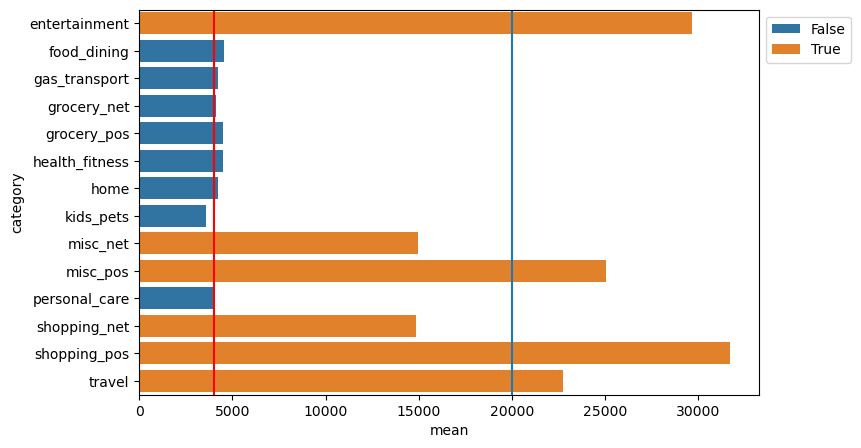

In [57]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=other_rules_merge, x="mean", y="category", hue="extreme", ax=ax)
ax.legend(bbox_to_anchor=(1, 1))
ax.axvline(20000)
ax.axvline(4000, color="r");

**Суммы `trans_freq_increase`**
- должно быть согласно таким параметрам min=2000, max=10000, mean=4000

In [58]:
trans_freq_amts = fraud_purchase_test.query("rule == 'trans_freq_increase'").groupby(["category"], as_index=False) \
                                        .agg({"amount":["min","max","mean","std"]}).round(2)
trans_freq_amts.head()

category  amount                           
                    min      max     mean      std
0   grocery_net  2000.0  7420.00  4438.20  1248.84
1      misc_net  2000.0  7552.39  4072.90  1267.16
2  shopping_net  2000.0  7209.88  4176.05  1211.98

**Проверка записанных файлов**

In [60]:
pd.read_parquet("./data/generated/latest/compr_client_txns.parquet").shape

(1291, 19)

In [63]:
# pd.read_parquet("./data/generated/history/compr_2025-07-19_184519/compr_client.parquet")
# r".\data\generated\history\compr_2025-07-19_184519\compr_client.parquet"

# Старый код, функции и т.д.

# Функция генерации весов для часов в периоде времени `get_time_for_trans` - Не модульная. Старая версия

In [ ]:
# def get_time_for_trans(trans_df, client_id, is_fraud, time_weights, timestamps, online=None, rule=None, geo_distance=None, lag=None):
#     """
#     trans_df - датафрейм с транзакциями. Откуда брать информацию по предыдущим транзакциям
#     client_id - id клиента, число, клиент чьи транзакции проверяются
#     is_fraud - boolean. Фрод или не фрод
#     time_weights - датафрейм с весами часов в периоде времени
#     timestamps - датафрейм с timestamps
#     online - boolean. Онлайн или оффлайн покупка. True or False
#     rule - строка. Название антифрод правила
#     geo_distance - число. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в метрах
#     lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
#           Это задержка именно между последней легитимной транзакцией и серией частых транзакций. Подразумевается что функция
#           get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.

#     Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
#     """
    
#     # timestamp последней транзакции клиента - может быть вынести фильтрацию по client_id из функции?
#     # Хотя наверное и вне функции все равно надо будет каждый раз обновлять состояние перед генерацией новой транзакции
    
#     last_txn_time = trans_df[trans_df.client_id == client_id].txn_time.max()
#     last_txn_unix = trans_df[trans_df.client_id == client_id].unix_time.max()
    
#     # Если нет предыдущей транзакции т.е. нет последнего времени
#     if not is_fraud and last_txn_time is pd.NaT:
#         # берем первый год всего времененного периода т.к. это первая транзакция, пусть будет создана в первом году
#         timestamps_1st_year = timestamps.loc[timestamps.timestamp.dt.year == timestamps.timestamp.dt.year.min()]

#         # семплируем час из весов времени, указав веса для семплирования
#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         # фильтруем основной датафрейм с диапазоном таймстемпов по этому часу
#         timestamps_subset = timestamps_1st_year.loc[timestamps_1st_year.hour == txn_hour]
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = (txn_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

#     # Если есть предыдущая транзакция

#     # Не фрод. Но есть предыдущая транзакция
#     elif not is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         pos_one_hour_diff = 3600
#         neg_one_hour_diff = -3600
        
#         # если время между текущей и последней транзакцией меньше часа в положительную сторону,
#         # то увеличим время чтобы разница была минимум час 
#         if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
#             time_addition = pos_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_addition
#             txn_time = pd.to_datetime(txn_unix, unit="s")
        
#         # если время между текущей и последней транзакцией меньше часа в отрицательную сторону, 
#         # то уменьшим время чтобы разница была минимум час
#         elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
#             time_subtraction = neg_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_subtraction
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
#     elif is_fraud and rule in ["fast_geo_change", "fast_geo_change_online"]:
#         # Выставим порог скорости перемещения между точками транзакций - м/с
#         # выше порога - детект как фрода. 
#         # Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций
#         # пусть будет порог в 800 км/ч. Делим на 3.6 для перевода в м/с
#         speed_threshold = 800 / 3.6
        
#         # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
#         # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
#         # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
#         # но в зависимости от расстояния мы берем разные границы для распределений, чтобы не было перекоса в очень быстрое время. 
#         # Также 20 минут я случайно взял как средний интервал для подобной фрод транзакции.
#         # Конечно же "скорость перемещения" может быть и больше в реальной жизни
        
#         if geo_distance < 1000_000:
#             fact_speed = random.randint(speed_threshold + 1, 3000) / 3.6
#         elif geo_distance >= 1000_000 and geo_distance <= 3000_000:
#             fact_speed = random.randint(speed_threshold + 1, 9000) / 3.6
#         elif geo_distance > 3000_000 and geo_distance <= 6000_000:
#             fact_speed = random.randint(speed_threshold + 1, 18000) / 3.6
#         else:
#             fact_speed = random.randint(speed_threshold + 1, 36000) / 3.6

#         # интервал времени между последней транзакцией и текущей фрод транзакцией
#         time_interval = geo_distance / fact_speed
        
#         txn_unix = last_txn_unix + time_interval
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Увеличение количества транзакций в единицу времени выше установленного порога в процентах.
#     # генерируем время
#     elif is_fraud and rule == "trans_freq_increase":
#         # семплируем таймстемп из таймстемпов по времени не ранее последней транзакции
#         timestamp_sample = timestamps.loc[timestamps.timestamp > last_txn_time].sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         lag_interval = 1800

#         # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства
#         freq = random.randint(1, 5) * 60
        
#         # если транзакция первая в серии фрод транзакций - аргумент lag=True
#         # и интервал между последней транзакцией менее 30 минут
#         # прибавить интервал 30 минут к семплированному времени текущей транзакции
#         if lag and trans_time_diff < lag_interval:
#             txn_unix = timestamp_sample.unix_time + lag_interval
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # Если lag=True, но не надо добавлять интервал
#         elif lag:
#             txn_unix = timestamp_sample.unix_time
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # для остальных случаев - когда это не первые фрод транзакции в серии
#         else:
#             txn_unix = last_txn_unix + freq
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Любой другой фрод
#     elif is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)

#         txn_unix = timestamp_sample.unix_time
#         txn_time = timestamp_sample.time

    
#     # время транзакции в виде timestamp и unix time
#     return txn_time, txn_unix
    

## Подфункция `ensure_min_interval_from_last_offline_trans` - когда есть предыдущие оффлайн транзакции и нужно обеспечить минимальный фиксированный интервал между транзакциями<br>
`Отменена`

In [ ]:
# def ensure_min_interval_from_last_offline_trans(last_txn_unix, timestamp_sample, time_diff=3600):
#     """
#     Обеспечивает минимальный фиксированный интервал от последней транзакции
#     -----------------------------------------------
#     last_txn_unix - unix время последней транзакции
#     timestamp_sample - случайно выбранная запись из датафрейма с таймстемпами
#     time_diff - желаемая минимальная разница от последней транзакции
    
#     Если сгенерированное время отличается от времени последней по времени транзакции на разницу меньше установленной
#     То вернет время с минимальной установленной разницей от последней транзакции.
#     Например либо час вперед либо час назад.
    
#     Если сгенерированное время раньше последней транзакции менее чем на time_diff, то вернет время последней транзакции минус time_diff.
#     Т.е. например на час раньше последней.
#     Если сгенерированное время позже последней транзакции менее чем на time_diff, то вернет время позже последней транзакции плюс time_diff.
#     Т.е. например на час позже последней.
#     Если разница в положительную либо в отрицательную сторону больше time_diff, то вернет исходное время без изменений.
#     """
    
#     timestamp_unix = timestamp_sample.unix_time.iloc[0]
#     trans_time_diff = timestamp_unix - last_txn_unix
#     pos_one_hour_diff = time_diff
#     neg_one_hour_diff = - time_diff
    
#     # если время между текущей и последней транзакцией меньше time_diff в положительную сторону,
#     # то увеличим время чтобы разница была минимум time_diff 
#     if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
#         print("Condition #1")
#         time_addition = pos_one_hour_diff - trans_time_diff
#         txn_unix = timestamp_unix + time_addition
#         txn_time = pd.to_datetime(txn_unix, unit="s")
    
#     # если время между текущей и последней транзакцией меньше time_diff в отрицательную сторону, 
#     # то уменьшим время чтобы разница была минимум time_diff
#     elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
#         print("Condition #2")
#         time_subtraction = neg_one_hour_diff - trans_time_diff
#         txn_unix = timestamp_unix + time_subtraction
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # если разница во времени больше установленной
#     else:
#         txn_unix = timestamp_unix
#         txn_time = pd.to_datetime(txn_unix, unit="s")
        
        
#     return txn_time, txn_unix

In [ ]:
# def check_min_interval_from_near_trans(client_txns, timestamp_sample, online, offline_time_diff=60, \
#                                        online_time_diff=6, online_ceil=60, general_diff=30, general_ceil=90):
#     """
#     Если для сгенерированного времени есть транзакции, которые по времени ближе заданного минимума, 
#     то создать время на основании времени последней транзакции + установленный минимальный интервал.
#     Проверяет время либо для оффлайн либо для онлайн транзакций.
#     Для оффлайн и онлайн транзакций можно поставить свои минимальные интервалы.
#     Для онлайн ставится и максимальный интервал. Время берется случайно и равновероятно из диапазона между online_time_diff и online_ceil
#     -----------------------------------------------

#     client_txns - датафрейм с транзакциями клиента.
#     timestamp_sample - случайно выбранная запись из датафрейма с таймстемпами
#     offline_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
#     online_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
#     online_ceil - int. желаемая максимальная разница от последней оффлайн транзакции в минутах
#     general_diff - int. минимально допустимая разница от последней транзакции противоположной по флагу online.
#     general_ceil - int. максимальная разница от последней транзакции противоположной по флагу online.
#                    При случае необходимости увеличения разрыва времени.
#     """
    
#     timestamp_unix = timestamp_sample.unix_time.iloc[0]

#     offline_txns = client_txns.loc[client_txns.online == False]
#     online_txns = client_txns.loc[client_txns.online == True]
    
#     # смотрим ближайшие оффлайн и онлайн транзакции по времени по модулю.
#     # В переменные записываем время по модулю до ближайшей транзакции онлайн или оффлайн типа
#     closest_offline_txn = offline_txns.unix_time.sub(timestamp_unix).abs().min()
#     closest_online_txn = online_txns.unix_time.sub(timestamp_unix).abs().min()

#     # перевод аргументов в секунды для работы с unix time
#     offline_time_diff= offline_time_diff * 60
#     online_time_diff= online_time_diff * 60
#     online_ceil= online_ceil * 60
#     general_diff = general_diff * 60
#     general_ceil = general_ceil * 60
    
#     # Если текущая транзакция - оффлайн и разница с ближайшей транзакцией меньше допустимой
#     if not online and closest_txn_by_time < offline_time_diff:
        
#         # извлекаем время последней оффлайн транзакции и прибавляем установленный интервал
#         last_offline_txn_unix = offline_txns.unix_time.max()
#         txn_unix = last_offline_txn_unix + offline_time_diff
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Если текущая транзакция - онлайн и разница с ближайшей транзакцией меньше допустимой
#     elif online and closest_txn_by_time < online_time_diff:
        
#         # извлекаем время последней онлайн транзакции и прибавляем установленный интервал
#         last_online_txn_unix = online_txns.unix_time.max()

#         # Берем случайное время между online_time_diff и online_ceil
#         online_random_diff = random.randint(online_time_diff, online_ceil)

#         # прибавляем установленный интервал ко времени последней транзакции
#         txn_unix = last_online_txn_unix + online_random_diff
#         txn_time = pd.to_datetime(txn_unix, unit="s")
        
#     # если разница во времени является допустимой. Просто берем текущий timestamp
#     else:
#         txn_unix = timestamp_unix
#         txn_time = pd.to_datetime(txn_unix, unit="s")  
        
    
#     # Проверка есть ли слишком близкие по времени транзакции противоположные по флагу online
#     # Любая последняя транзакция. Если последняя транзакция такая же по флагу online, то разница
#     # Уже проверена и обеспечена в прошлом if-else блоке, и ничего не изменится.
#     last_txn_unix = client_txns.unix_time.max()
#     last_txn_diff = abs(last_txn_unix - txn_unix)
    
#     if last_txn_diff < general_diff:
#         general_random_diff = random.randint(general_diff, general_ceil)
#         txn_unix = last_txn_unix + general_random_diff
#         txn_time = pd.to_datetime(txn_unix, unit="s")
        
#     return txn_time, txn_unix

# Немодульная `get_time_for_trans` - старая версия

# `check_min_interval_from_near_trans` - до рефактора и добавления условий

In [ ]:
# def get_time_for_trans(trans_df, client_id, is_fraud, time_weights, timestamps, online=None, rule=None, geo_distance=None, lag=None):
#     """
#     trans_df - датафрейм с транзакциями. Откуда брать информацию по предыдущим транзакциям
#     client_id - id клиента, число, клиент чьи транзакции проверяются
#     is_fraud - boolean. Фрод или не фрод
#     time_weights - датафрейм с весами часов в периоде времени
#     timestamps - датафрейм с timestamps
#     online - boolean. Онлайн или оффлайн покупка. True or False
#     rule - строка. Название антифрод правила
#     geo_distance - число. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в метрах
#     lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
#           Это задержка именно между последней легитимной транзакцией и серией частых транзакций. Подразумевается что функция
#           get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.

#     Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
#     """
    
#     # timestamp последней транзакции клиента - может быть вынести фильтрацию по client_id из функции?
#     # Хотя наверное и вне функции все равно надо будет каждый раз обновлять состояние перед генерацией новой транзакции
    
#     last_txn_time = trans_df[trans_df.client_id == client_id].txn_time.max()
#     last_txn_unix = trans_df[trans_df.client_id == client_id].unix_time.max()
    
#     # Если нет предыдущей транзакции т.е. нет последнего времени
#     if not is_fraud and last_txn_time is pd.NaT:
#         # берем первый год всего времененного периода т.к. это первая транзакция, пусть будет создана в первом году
#         timestamps_1st_year = timestamps.loc[timestamps.timestamp.dt.year == timestamps.timestamp.dt.year.min()]

#         # семплируем час из весов времени, указав веса для семплирования
#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         # фильтруем основной датафрейм с диапазоном таймстемпов по этому часу
#         timestamps_subset = timestamps_1st_year.loc[timestamps_1st_year.hour == txn_hour]
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = (txn_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

#     # Если есть предыдущая транзакция

#     # Не фрод. Но есть предыдущая транзакция
#     elif not is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         pos_one_hour_diff = 3600
#         neg_one_hour_diff = -3600
        
#         # если время между текущей и последней транзакцией меньше часа в положительную сторону,
#         # то увеличим время чтобы разница была минимум час 
#         if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
#             time_addition = pos_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_addition
#             txn_time = pd.to_datetime(txn_unix, unit="s")
        
#         # если время между текущей и последней транзакцией меньше часа в отрицательную сторону, 
#         # то уменьшим время чтобы разница была минимум час
#         elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
#             time_subtraction = neg_one_hour_diff - trans_time_diff
#             txn_unix = txn_unix + time_subtraction
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
#     elif is_fraud and rule in ["fast_geo_change", "fast_geo_change_online"]:
#         # Выставим порог скорости перемещения между точками транзакций - м/с
#         # выше порога - детект как фрода. 
#         # Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций
#         # пусть будет порог в 800 км/ч. Делим на 3.6 для перевода в м/с
#         speed_threshold = 800 / 3.6
        
#         # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
#         # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
#         # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
#         # но в зависимости от расстояния мы берем разные границы для распределений, чтобы не было перекоса в очень быстрое время. 
#         # Также 20 минут я случайно взял как средний интервал для подобной фрод транзакции.
#         # Конечно же "скорость перемещения" может быть и больше в реальной жизни
        
#         if geo_distance < 1000_000:
#             fact_speed = random.randint(speed_threshold + 1, 3000) / 3.6
#         elif geo_distance >= 1000_000 and geo_distance <= 3000_000:
#             fact_speed = random.randint(speed_threshold + 1, 9000) / 3.6
#         elif geo_distance > 3000_000 and geo_distance <= 6000_000:
#             fact_speed = random.randint(speed_threshold + 1, 18000) / 3.6
#         else:
#             fact_speed = random.randint(speed_threshold + 1, 36000) / 3.6

#         # интервал времени между последней транзакцией и текущей фрод транзакцией
#         time_interval = geo_distance / fact_speed
        
#         txn_unix = last_txn_unix + time_interval
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Фрод. Увеличение количества транзакций в единицу времени выше установленного порога в процентах.
#     # генерируем время
#     elif is_fraud and rule == "trans_freq_increase":
#         # семплируем таймстемп из таймстемпов по времени не ранее последней транзакции
#         timestamp_sample = timestamps.loc[timestamps.timestamp > last_txn_time].sample(n=1, replace=True)
#         trans_time_diff = timestamp_sample.unix_time - last_txn_unix
#         lag_interval = 1800

#         # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства
#         freq = random.randint(1, 5) * 60
        
#         # если транзакция первая в серии фрод транзакций - аргумент lag=True
#         # и интервал между последней транзакцией менее 30 минут
#         # прибавить интервал 30 минут к семплированному времени текущей транзакции
#         if lag and trans_time_diff < lag_interval:
#             txn_unix = timestamp_sample.unix_time + lag_interval
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # Если lag=True, но не надо добавлять интервал
#         elif lag:
#             txn_unix = timestamp_sample.unix_time
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#         # для остальных случаев - когда это не первые фрод транзакции в серии
#         else:
#             txn_unix = last_txn_unix + freq
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Любой другой фрод
#     elif is_fraud:

#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)

#         txn_unix = timestamp_sample.unix_time
#         txn_time = timestamp_sample.time

    
#     # время транзакции в виде timestamp и unix time
#     return txn_time, txn_unix
    

# Функция генератор одной легитимной POS транзакции `generate_one_legit_trans` - `первые тест сделаны` версия до рефактора

In [ ]:
# def generate_one_legit_trans(client_info, client_trans_df, category, merchants_df, online_merchant_ids, timestamps, \
#                              timestamps_1st_month, time_weights_dict):
#     """
#     Генерация одной легальной транзакции для клиента
#     ------------------------------------------------
#     client_info - namedtuple, полученная в результате итерации с помощью .itertuples() через датафрейм с информацией о клиентах
#     client_trans_df - датафрейм с транзакциями клиента.
#     category - датафрейм в одну запись с категорией и её характеристиками
#     merchants_df - датафрейм с оффлайн мерчантами заранее отфильтрованный по городу клиента т.к. это легальные транзакции
#     online_merchant_ids - id для онлайн мерчантов
#     time_weights_dict - веса для часов времени в виде словаря с: датафреймом с весами, названием распределения и цветом для графика
#     """

#     # Записываем данные клиента в переменные
#     client_id = client_info.client_id
#     client_area = client_info.area
#     client_area_lat = client_info.lat
#     client_area_lon = client_info.lon
#     client_ip = client_info.home_ip
    
    
#     # category = categories.sample(1, replace=True, weights=categories.share)
#     category_name = category["category"].iloc[0]
#     round_clock = category["round_clock"].iloc[0]
#     online = category["online"].iloc[0]
#     # средняя сумма для этой категории
#     amt_mean = category["avg_amt"].iloc[0]
#     # стандартное отклонение сумм для этой категории
#     amt_std = category["amt_std"].iloc[0]
    
#     # случайно сгенерированная сумма транзакции, но не менее 1
#     amount = max(1, np.random.normal(amt_mean, amt_std))

    
#     # 1. Offline_24h_Legit - круглосуточные оффлайн покупки
#     if not online and round_clock:
#         time_weights = time_weights_dict["Offline_24h_Legit"]["weights"]
#         merchant = merchants_df.loc[merchants_df.category == category_name].sample(1, replace=True)
#         merchant_id = merchant["merchant_id"].iloc[0]
#         trans_lat = merchant["merchant_lat"].iloc[0]
#         trans_lon = merchant["merchant_lon"].iloc[0]
#         status = "approved"
        
#         txn_time, txn_unix = get_time_for_trans(trans_df=client_trans_df, is_fraud=False, time_weights=time_weights, \
#                                                 timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
#                                                 online=online)
#         pos_txn = {
#                     "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                     "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                     "trans_city":client_area, "trans_lat": trans_lat, "trans_lon": trans_lon,"trans_ip":"not applicable",
#                     "account_to": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
#                     "rule":"not applicable"
#                     }


#     # 2. Online_Legit - Онлайн покупки
#     elif online:
#         time_weights = time_weights_dict["Online_Legit"]["weights"]
#         merchant_id = online_merchant_ids.sample(n=1).iloc[0]
#         # локация клиента по IP. Т.к. это не фрод. Просто записываем координаты города клиента
#         trans_lat = client_area_lat
#         trans_lon = client_area_lon
    
#         txn_time, txn_unix = get_time_for_trans(trans_df=client_trans_df, is_fraud=False, time_weights=time_weights, \
#                                                 timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
#                                                 online=online)
#         pos_txn = {
#                     "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                     "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                     "trans_city":client_area, "trans_lat": trans_lat, "trans_lon": trans_lon, "trans_ip":client_ip,
#                     "account_to": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
#                     "rule":"not applicable"
#                     }

#     # 3. Offline_Day_Legit - Оффлайн покупки. Дневные категории.
#     elif not online and not round_clock:
#         time_weights = time_weights_dict["Offline_Day_Legit"]["weights"]
#         merchant = merchants_df.loc[merchants_df.category == category_name].sample(1, replace=True)
#         merchant_id = merchant["merchant_id"].iloc[0]
#         trans_lat = merchant["merchant_lat"].iloc[0]
#         trans_lon = merchant["merchant_lon"].iloc[0]
#         status = "approved"
        
#         txn_time, txn_unix = get_time_for_trans(trans_df=client_trans_df, is_fraud=False, time_weights=time_weights, \
#                                                 timestamps=timestamps, timestamps_1st_month=timestamps_1st_month, \
#                                                 online=online)
#         pos_txn = {
#                     "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                     "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                     "trans_city":client_area, "trans_lat": trans_lat, "trans_lon": trans_lon,"trans_ip":"not applicable",
#                     "account_to": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
#                     "rule":"not applicable"
#                     }


#     return pos_txn

# Основная функция генератор POS транзакций - изначальная. - старая, самая первая версия. До разбивки на легальные и фрод

In [ ]:
# Генерация POS транзакций
# def generate_legit_pos_transactions(client_info, start_date, end_date, time_weights_dict, categories, rules, trans_df, merchants_df, \
#                               area_centers, fraud_ips, online_merchant_ids, num=50, fraud_rate=0.01):
#     """
#     client_info  - датафрейм с данными клиента
#     start_date - первая транзакция
#     end_date - последняя транзакция
#     time_weights_dict - веса для часов времени в виде словаря с: датафреймом с весами, названием распределения и цветом для графика
#     categories - датафрейм с категориями и их характеристиками
#     rules -  датафрейм с антифрод правилами и их весами fraud_ips - датафрейм с фродовыми ip адресами
#     trans_df - датафрейм с транзакциями.
#                Куда их писать и куда обращаться за информацией по предыдущим транзакциям
#     merchants_df - датафрейм с оффлайн мерачантами
#     area_centers - названия городов с координатами центра
#     online_merchant_ids - id для онлайн мерчантов
#     num - количество транзакций на клиента
#     fraud_rate - доля фрода во всех транзакциях
#     """

#     # Датафрейм timestamp-ов откуда будет семплироваться время
#     timestamps = pd.DataFrame(pd.Series(pd.date_range(pd.to_datetime(start_date, format="%Y-%m-%d"), \
#                                                   pd.to_datetime(end_date, format="%Y-%m-%d"), freq='min'), name="timestamp"))
#     timestamps["hour"] = timestamps.timestamp.dt.hour
#     timestamps["unix_time"] = (timestamps.timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
#     # timestamps = pd.Series(pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='min'))
    
    



#     # итерируемся через уникальных клиентов
#     for row in client_info.itertuples():
#         pos_txns = [] # сюда временно будут добавляться созданные транзакции для текущего клиента

#         # данные клиента
#         client_id = row.client_id
#         client_area = row.area
#         client_area_geometry = row.geometry
#         client_ip = row.home_ip
        
#         # цикл создания n транзакций для текущего клиента
#         for _ in range(num):

#             # будет ли транзакция фродом или нет. Процент фрод транзакций зависит от выставленного fraud rate
#             is_fraud = random.random() < fraud_rate
            
#             #########################
#             # ЛЕГЕТИМНЫЕ ТРАНЗАКЦИИ #
#             #########################
#             if not is_fraud:
#                 # случайный выбор категории транзакции. В зависимости от частоты категории
#                 category = categories.sample(1, replace=True, weights=categories.share)
#                 category_name = category["category"].iloc[0]
#                 round_clock = category["round_clock"].iloc[0]
#                 online = category["online"].iloc[0]
#                 # средняя сумма для этой категории
#                 amt_mean = category["avg_amt"].iloc[0]
#                 # стандартное отклонение сумм для этой категории
#                 amt_std = category["amt_std"].iloc[0]
#                 # случайно сгенерированная сумма транзакции, но не менее 1
#                 amount = max(1, np.random.normal(amt_mean, amt_std))

#             # СТРОКА ДЛЯ ТЕСТОВ
#             # print(f"is_fraud:{is_fraud}, category_name: {category_name}")

            
#             # 1. Offline_24h_Legit - круглосуточные оффлайн покупки - НЕ фрод
#             if not is_fraud and not online and round_clock:
#                 time_weights = time_weights_dict["Offline_24h_Legit"]["weights"]
#                 merchant = merchants_df.loc[(merchants_df["area"] == client_area) & (merchants_df.category == category_name)].sample(1, replace=True)
#                 merchant_id = merchant["merchant_id"].iloc[0]
#                 trans_loc = merchant["geometry"].iloc[0]
#                 status = "approved"
                
#                 txn_time, txn_unix = get_time_for_trans(trans_df=trans_df, client_id=client_id, is_fraud=is_fraud, time_weights=time_weights, \
#                                                         timestamps=timestamps, online=False)
#                 pos_txns.append({
#                 "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                 "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                 "trans_loc": trans_loc, "client_ip":"not applicable",
#                 "account_to": np.nan, "is_fraud": is_fraud, "status":"approved"
#             })


#             # 2. Online_Legit - Онлайн покупки - НЕ фрод
#             elif not is_fraud and online:
#                 time_weights = time_weights_dict["Online_Legit"]["weights"]
#                 merchant_id = online_merchant_ids.sample(n=1).iloc[0]
#                 # локация клиента по IP. Т.к. это не фрод. То просто ищем координаты города по городу клиента
#                 trans_loc = area_centers.loc[area_centers["area"] == client_area]

#                 txn_time, txn_unix = get_time_for_trans(trans_df=trans_df, client_id=client_id, is_fraud=is_fraud, time_weights=time_weights, \
#                                                         timestamps=timestamps, online=True)
#                 pos_txns.append({
#                 "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": round(amount, 2), "type": "purchase",
#                 "channel": "POS", "category": category_name, "online": online, "merchant_id": merchant_id,
#                 "trans_loc": trans_loc, "client_ip":"not applicable",
#                 "account_to": np.nan, "is_fraud": is_fraud, "status":"approved"
#             })


            
#             #############################
#             # ГЕНЕРАЦИЯ ФРОД ТРАНЗАКЦИЙ #
#             #############################    

#             if is_fraud:
#                 # случайный выбор категории транзакции. В зависимости от частоты фрода в категории
#                 category = categories.sample(1, replace=True, weights=categories.fraud_share)
#                 category_name = category["category"].iloc[0]
#                 round_clock = category["round_clock"].iloc[0]
#                 online = category["online"].iloc[0]
#                 # средняя сумма для этой категории
#                 amt_mean = category["avg_amt"].iloc[0]
#                 # стандартное отклонение сумм для этой категории
#                 amt_std = category["amt_std"].iloc[0]
#                 # случайно сгенерированная сумма транзакции, но не менее 1
#                 # amount = max(1, np.random.normal(amt_mean, amt_std)) - amount для фрода генерится после определения правила


        
#         # Список словарей с готовыми транзакциями для одного клиента делаем геодатафреймом
#         # и присоединяем к основному геодатафрейму
#         trans_df_one_client = gpd.GeoDataFrame(pos_txns)
#         trans_df = pd.concat([trans_df, trans_df_one_client], ignore_index=True)

#     # Возвращаем целый датафрейм. Колонкой с геометрией устанавливаем trans_loc
#     return trans_df.set_geometry("trans_loc")

# Разбитая на подфункции функция `get_time_for_trans` - старая версия, до рефактора

In [ ]:
# def get_time_for_trans(trans_df, is_fraud, time_weights, timestamps, timestamps_1st_month, \
#                        online=None, rule=None, geo_distance=None, lag=None):
#     """
#     trans_df - датафрейм с транзакциями текущего клиента. Откуда брать информацию по предыдущим транзакциям клиента
#     is_fraud - boolean. Фрод или не фрод
#     time_weights - датафрейм с весами часов в периоде времени
#     timestamps - датафрейм с timestamps
#     timestamps_1st_month - сабсет timestamps отфильтрованный по первому месяцу и, если применимо, году. Чтобы генерировать первые транзакции
#     online - boolean. Онлайн или оффлайн покупка. True or False
#     rule - str. Название антифрод правила
#     geo_distance - int. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в километрах
#     lag - boolean. Задержка по времени от предыдущей транзакции. Нужна для моделирования увеличения частоты транзакций.
#           Это задержка именно между последней легитимной транзакцией и серией частых фрод транзакций. Подразумевается что функция
#           get_time_for_trans будет использована в цикле, и для первой итерации lag будет True.

#     Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
#     """
    
#     # timestamp последней транзакции клиента - может быть вынести фильтрацию по client_id из функции?
#     # Да. Вынесу фильтрацию по client_id из функции. Т.к. транзакции планируется генерировать в цикле итерируясь через клиентов.
    
#     last_txn_time = trans_df.txn_time.max()
#     last_txn_unix = trans_df.unix_time.max()
#     offline_txns = trans_df[trans_df.online == False]
#     online_txns = trans_df[trans_df.online == True]
    

#     ########################
#     # ЛЕГАЛЬНЫЕ ТРАНЗАКЦИИ #
#     ########################
    
#     # Если нет никакой предыдущей транзакции т.е. нет последнего времени совсем
#     if not is_fraud and last_txn_time is pd.NaT:
#         # берем первый месяц всего времененного периода т.к. это первая транзакция, пусть будет создана в первом месяце
#         # timestamps_1st_month = timestamps.loc[timestamps.timestamp.dt.month == timestamps.timestamp.dt.month.min()]

#         # получаем timestamp и unix время транзакции
#         txn_time, txn_unix = sample_time_for_trans(timestamps=timestamps_1st_month, time_weights=time_weights)

#         # время транзакции в виде timestamp и unix time. Здесь отдельный return, чтобы прервать дальнейшее выполнений функции
#         # т.к. это отдельный блок if-statements
#         return txn_time, txn_unix

    
#     # Если есть предыдущая транзакция

#     # берем случайный час передав веса часов
#     txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
    
#     # фильтруем по этому часу timestamp-ы и семплируем timestamp уже с равной вероятностью
#     timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
#     timestamp_sample = timestamps_subset.sample(n=1, replace=True)
        
#     # Не фрод. Текущая транзакция оффлайн и есть предыдущая оффлайн транзакция.
#     # Обеспечение минимального интервала времени между оффлайн транзакциями
#     # Это чтобы легальные транзакции не попали под фрод из-за частоты выполнения или быстроты физического перемещения клиента между транзакциями
    
#     if not is_fraud and not online and not offline_txns.empty:

#         # передаем функции сабсет из оффлайн транзакций, семплированный timestamp, онлайн ставим False, 
#         # минимально допустимая разница между другими оффлайн транзакциями - 60 минут
        
#         txn_time, txn_unix = check_min_interval_from_near_trans(txns_subset=offline_txns, timestamp_sample=timestamp_sample, online=False, \
#                                                                 offline_time_diff=60)

#     # Не фрод. Текущая транзакция онлайн и есть предыдущая онлайн транзакция.
#     # Обеспечение минимального интервала времени между онлайн транзакциями
    
#     elif not is_fraud and online and not online_txns.empty:
        
#         # передаем функции сабсет из оффлайн транзакций, семплированный timestamp, онлайн ставим True, 
#         # минимально допустимая разница между другими онлайн транзакциями - 6 минут
#         # разница от последней транзакции: от 6 до 60 минут - для случая если timestamp близко по времени к существующей транзакции
        
#         txn_time, txn_unix = check_min_interval_from_near_trans(txns_subset=offline_txns, timestamp_sample=timestamp_sample, online=False, \
#                                                                 online_time_diff=6, online_ceil=60)

#     # Случай когда есть любые предыдущие транзакции, но они другого типа: либо текущая категория онлайн, а предыдущие транзакции все оффлайн
#     # либо текущая категория оффлайн, а предыдущие транзакции все онлайн
#     elif not is_fraud:
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = pd_timestamp_to_unix(txn_time)
        

#     ########
#     # ФРОД #
#     ########

#     # Фрод. Правила: другая гео за короткое время либо по локации оффлайн мерчанта либо по новому ip адресу
#     elif is_fraud and rule in ["fast_geo_change", "fast_geo_change_online"]:
#         txn_time, txn_unix = generate_time_fast_geo_jump(last_txn_unix, geo_distance, threshold=800)

    
#     # Фрод. Увеличение количества транзакций в единицу времени выше установленного порога в процентах.
#     elif is_fraud and rule == "trans_freq_increase":
#         txn_time, txn_unix = gen_time_for_frequent_trans(last_txn_time, last_txn_unix, timestamps, time_weights, lag, \
#                                                          lag_interval=30, freq_low=1, freq_high=5)

#     # Фрод. Любое другое правило, где сабсет timestamp-ов семплирован ранее в соответствии с переданными весами
#     elif is_fraud:
#         # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
#         txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
#         txn_unix = pd_timestamp_to_unix(txn_time)


#     # время транзакции в виде timestamp и unix time
#     return txn_time, txn_unix

# Подфункция `check_min_interval_from_near_trans` - когда есть предыдущие транзакции - `Версия с багом`

In [ ]:
# def check_min_interval_from_near_trans(client_txns, timestamp_sample, online, round_clock, offline_time_diff=60, \
#                                        online_time_diff=6, online_ceil=60, general_diff=30, general_ceil=90, test=False):
#     """
#     Если для сгенерированного времени есть транзакции, которые по времени ближе заданного минимума, 
#     то создать время на основании времени последней транзакции + установленный минимальный интервал.
#     Учитывает разницу между типами транзакций: онлайн-онлайн, онлайн-оффлайн, оффлайн-оффлайн.
#     Можно поставить свои минимальные интервалы для случаев: онлайн-онлайн, онлайн-оффлайн, оффлайн-оффлайн. 
#     Для оффлайн-оффлайн - один фиксированный интервал.
#     Для онлайн-онлайн задается минимум и максимум откуда интервал берется с равной вероятностью
#     Для оффлайн-онлайн задается минимум и максимум откуда интервал берется с равной вероятностью
#     -----------------------------------------------

#     client_txns - датафрейм с транзакциями клиента.
#     timestamp_sample - случайно выбранная запись из датафрейма с таймстемпами
#     online - boolean. Онлайн или оффлайн категория
#     round_clock - boolean. Круглосуточная или дневная категория.
#     offline_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
#     online_time_diff - int. желаемая минимальная разница от последней оффлайн транзакции в минутах
#     online_ceil - int. желаемая максимальная разница от последней оффлайн транзакции в минутах
#     general_diff - int. минимально допустимая разница от последней транзакции противоположной по флагу online.
#     general_ceil - int. максимальная разница от последней транзакции противоположной по флагу online.
#                    При случае необходимости увеличения разрыва времени.
#     test - boolean. True - логировать исполнение функции в csv.
#     ------------------------------------------------
#     Возвращает pd.Timestamp и int unix время в секундах 
#     """

#     # перевод аргументов в секунды для работы с unix time
#     offline_time_diff= offline_time_diff * 60
#     online_time_diff= online_time_diff * 60
#     online_ceil= online_ceil * 60
#     general_diff = general_diff * 60
#     general_ceil = general_ceil * 60

    
#     timestamp_unix = timestamp_sample.unix_time.iloc[0]
#     # Копия, чтобы не внести изменения в исходный датафрейм
#     client_txns = client_txns.copy()
#     client_txns["abs_time_proximity"] = client_txns.unix_time.sub(timestamp_unix).abs()

#     # Запись о ближайшей по времени транзакции
#     closest_txn = client_txns.loc[client_txns.abs_time_proximity == client_txns.abs_time_proximity.min()]
#     # Онлайн или не онлайн ближайшая по времени транзакция
#     closest_online_flag = closest_txn.online.iloc[0]
#     # Разница семплированного timestamp-а с ближайшей по времени транзакцией
#     closest_time_diff = closest_txn.abs_time_proximity.iloc[0]

#     # Запись о последней транзакции
#     last_txn = client_txns.loc[client_txns.unix_time == client_txns.unix_time.max()]
#     # Онлайн или не онлайн последняя транзакция
#     last_online_flag = last_txn.online.iloc[0]
#     # unix время
#     last_txn_unix = last_txn.unix_time.iloc[0]
    
#     # Если, создаваемая транзакция оффлайн и ближайшая по времени тоже оффлайн
#     # И разница меньше допустимой
#     if not online and not closest_online_flag and closest_time_diff < offline_time_diff:
#         close_flag = "offline_to_offline"

#     # Если оффлайн транзакция и ближайшая онлайн. И разница меньше допустимой
#     elif not online and closest_online_flag and closest_time_diff < general_diff:
#         close_flag = "offline_to_online"
        
#     # Если, создаваемая транзакция онлайн и ближайшая по времени тоже онлайн
#     # И разница меньше допустимой
#     elif online and closest_online_flag and closest_time_diff < online_time_diff:
#         close_flag = "online_to_online"

#     # Если онлайн транзакция и ближайшая оффлайн. И разница меньше допустимой
#     elif online and not closest_online_flag and closest_time_diff < general_diff:
#         close_flag = "online_to_offline"
        
#     # Если нет транзакций ближе установленной разницы
#     # Просто берем изначальный timestamp
#     else:
#         close_flag = "No flag"
#         txn_unix = timestamp_unix
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Если транзакция близка по времени к другой, то согласно типам транзакций
#     # создаем другое время на основании времени и типа последней и текущей транзакции
#     if close_flag in ["offline_to_offline", "offline_to_online"]:
#         # Если последняя транзакция Онлайн. То добавляем случайную разницу для онлайн и оффлайн транзакций в установленном диапазоне
#         if last_online_flag:
#             general_random_diff = random.randint(general_diff, general_ceil)
#             txn_unix = last_txn_unix + general_random_diff
#             txn_time = pd.to_datetime(txn_unix, unit="s")
            
#         # Если последняя транзакция Оффлайн. То добавляем допустимую разницу между оффлайн транзакциями
#         elif not last_online_flag:
#             txn_unix = last_txn_unix + offline_time_diff
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Если текущая транзакция онлайн и есть онлайн/оффлайн транзакция с разницей меньше допустимой
#     elif close_flag in ["online_to_online", "online_to_offline"]:
#         # Если последняя транзакция онлайн. То добавляем случайную разницу для онлайн транзакций в установленном диапазоне
#         if last_online_flag:
#             online_random_diff = random.randint(online_time_diff, online_ceil)
#             txn_unix = last_txn_unix + online_random_diff
#             txn_time = pd.to_datetime(txn_unix, unit="s")
            
#         # Если последняя транзакция Оффлайн. То добавляем случайную разницу для онлайн и оффлайн транзакций в установленном диапазоне
#         elif not last_online_flag:
#             general_random_diff = random.randint(general_diff, general_ceil)
#             txn_unix = last_txn_unix + general_random_diff
#             txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Проверка и корректировка времени, на случай если категория дневная, и время выходит за рамки этой категории
#     # Если час меньше 8 и больше 21. Т.е. ограничение 08:00-21:59
#     if not online and not round_clock and (txn_time.hour < 8 or txn_time.hour > 21):
#         txn_time = txn_time + pd.Timedelta(10, unit="h")
#         txn_unix = pd_timestamp_to_unix(txn_time)
        
#     if not test:
#         return txn_time, txn_unix
        
#     # В тестовом режиме логируем некоторые данные в csv
#     else:
#         log_check_min_time(client_id=client_txns.client_id.iloc[0], txn_time=txn_time, txn_unix=txn_unix, online=online, closest_txn=closest_txn, \
#                            closest_online_flag=closest_online_flag, last_txn=last_txn, last_online_flag=last_online_flag, close_flag=close_flag)
#         return txn_time, txn_unix

## Подфункция генерации времени транзакции для правила `trans_freq_increase` - timestamp семплируется `первая версия с lag`

In [327]:
# def gen_time_for_frequent_trans(last_txn_time, last_txn_unix, timestamps, time_weights, lag, lag_interval=30, \
#                                 freq_low=1, freq_high=5, test=False, test_timestamp=None):
#     """
#     Функция для имитации времени нескольких частых транзакций подряд.
#     -------------------------------------------------
#     last_txn_time - pd.Timestamp последней транзакции
#     last_txn_unix - unix время последней транзакции в секундах
#     timestamps - pd.DataFrame с диапазоном pd.Timestamp-ов и их unix аналогом в секундах и колонкой часа timestamp-а
#     lag - True или False. Является ли текущая транзакция первой в серии мошеннических/подозрительных учащенных транзакций.
#           При True будет добавлен лаг равный lag_interval от предыдущей легальной транзакции
#     lag_interval - int. лаг от предыдущей транзакции в минутах
#     freq_low - int. минимальный разрыв между транзакциями в цепочке фрод транзакций, в минутах
#     freq_high - int. максимальный разрыв между транзакциями в цепочке фрод транзакций, в минутах
#     test - True или False. Тестируем мы функцию или нет. Если тестируем, то надо передать test_timestamp
#     test_timestamp - str. Дата и время в формате '1899-01-01 00:00:00'. Это замена семплируемуго внутри
#                      функции timestamp-а, который проверяется на разницу во времени с последней легальной транзакцией.
#     --------------------------------------------------
#     При test == False возвращает pd.Timestamp и unix time в секундах
#     При test == True возвращает pd.Timestamp, unix time в секундах и получившуюся разницу времени с предыдущей транзакцией в минутах в виде int
#     """

#     # перевод минут в секунды для удобства подсчета с unix time
#     lag_interval = lag_interval * 60
    
#     # если транзакция первая в серии фрод транзакций - аргумент lag равен True. И не режим тестирования функции
#     if lag and not test:
        
#         # Фильтруем timestamp-ы, оставляя те, что после последней легитимной транзакции
#         timestamp_after_last_trans = timestamps.loc[timestamps.timestamp > last_txn_time]

#         # Семплируем час первой транзакции, передав веса часов.
#         # Затем фильтруем timestamp-ы по этому часу
#         txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
#         timestamps_subset = timestamp_after_last_trans.loc[timestamp_after_last_trans.hour == txn_hour]
#         # семплируем таймстемп из таймстемпов по времени не ранее последней транзакции
#         timestamp_sample = timestamps_subset.sample(n=1, replace=True)
#         # Узнаем разницу между timestamp-ом и последней транзакцией
#         trans_time_diff = timestamp_sample.unix_time.sub(last_txn_unix).iloc[0]

#     # Если режим тестирования. То timestamp_sample у нас это не семпл, а переданный в аргументе timestamp
#     elif lag and test:
#         timestamp_sample = pd.DataFrame({"timestamp":pd.Series(dtype="datetime64[s]"), "unix_time":pd.Series(dtype="int64")})
#         timestamp_sample.loc[0, "timestamp"] = pd.to_datetime(test_timestamp, format="%Y-%m-%d %H:%M:%S")
#         timestamp_sample.loc[0, "unix_time"] = pd_timestamp_to_unix(timestamp_sample.timestamp.iloc[0])
#         # Узнаем разницу между timestamp-ом и последней транзакцией
#         trans_time_diff = timestamp_sample.unix_time.iloc[0] - last_txn_unix


#     # если транзакция первая в серии фрод транзакций
#     # и интервал между последней транзакцией менее 30 минут
#     # прибавить интервал 30 минут к семплированному времени текущей транзакции
#     if lag and trans_time_diff < lag_interval:
#         # print("Condition #1")
#         time_addition = lag_interval - trans_time_diff
#         txn_unix = timestamp_sample.unix_time.iloc[0] + time_addition
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # Если lag равен True, но не надо добавлять интервал
#     elif lag:
#         # print("Condition #2")
#         txn_unix = timestamp_sample.unix_time.iloc[0]
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     # для остальных случаев - когда это не первые фрод транзакции в серии
#     # просто добавляем 1-5 минут ко времени предыдущей транзакции
#     else:
#         # частота фрод транзакций. от 1 до 5 минут. Выразим в секундах для удобства расчетов
#         freq = random.randint(freq_low, freq_high) * 60
#         txn_unix = last_txn_unix + freq
#         txn_time = pd.to_datetime(txn_unix, unit="s")

#     if not test:
#         return txn_time, txn_unix
    
#     elif test and lag:
#         return txn_time, txn_unix
        
#     elif test and not lag:
#         return txn_time, txn_unix, freq

**Старые тесты `gen_time_for_frequent_trans`**

In [328]:
# weights_for_freq_trans = time_weights["Online_Fraud"]["weights"]

# Диапазон timestamp-ов для семплирования

# timestamps_freq_test = create_timestamps_range_df(start="2023-09-20", end="2023-09-21")

# # Датафрейм с последней транзакцией - перезапустить ячейку для теста ниже

# last_time = pd.to_datetime("2023-09-20 09:14:00", format="%Y-%m-%d %H:%M:%S")
# last_unix = pd_timestamp_to_unix(last_time)

# # условно основной датафрейм с транзакциями. У нас там одна легальная последняя транзакция на данный момент

# trans_test_freq_time = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account_to', 'is_fraud', 'is_suspicious']]
# trans_test_freq_time.loc[0, ["txn_time","unix_time"]] = last_time, last_unix
# print(f"last_time, last_unix: {last_time, last_unix}")
# trans_test_freq_time

# # в этом скрипте нужно проверить с условиями:
# # 1. test_timestamp равен txn_time в исходном датафрейме с последней легальной транзакцией
# # 2. test_timestamp больше txn_time в исходном датафрейме с последней легальной транзакцией,на не более чем на 29 минут
# # 3. test_timestamp больше txn_time в исходном датафрейме с последней легальной транзакцией, на 30 и более минут

# trans_freq_temp_df = transactions.copy().loc[:, ['txn_time', 'unix_time','online','account_to', 'is_fraud', 'is_suspicious']]
# last_time = trans_test_freq_time.txn_time.max()
# last_unix = trans_test_freq_time.unix_time.max()

# test_mode = 3

# if test_mode == 1:
#     test_timestamp = last_time
# elif test_mode == 2:
#     test_timestamp = last_time + pd.Timedelta(7, unit="m")
# elif test_mode == 3:
#     test_timestamp = last_time + pd.Timedelta(30, unit="m")


# freq_values = []


# for i in range(1,6):
#     if i == 1:
#         lag = True

#         txn_time, txn_unix = gen_time_for_frequent_trans(last_txn_time=last_time, last_txn_unix=last_unix, timestamps=timestamps_freq_test, \
#                                                          time_weights=weights_for_freq_trans, lag=lag, \
#                                                          test=True, test_timestamp=test_timestamp)
        
#     else:
#         lag = False
    
#         txn_time, txn_unix, freq = gen_time_for_frequent_trans(last_txn_time=last_time, last_txn_unix=last_unix, timestamps=timestamps_freq_test, \
#                                                          time_weights=weights_for_freq_trans, lag=lag, \
#                                                          test=True, test_timestamp=test_timestamp)
#         freq_values.append(freq / 60)
        
#     trans_freq_temp_df.loc[i, "txn_time"] = txn_time
#     trans_freq_temp_df.loc[i, "unix_time"] = txn_unix
#     trans_freq_temp_df.loc[i, "is_fraud"] = True

    
#     last_time = txn_time
#     last_unix = txn_unix

# # средняя частота фрод транзакций - всех, кроме первой фрод транзакции
# print("\n\n Mean freq: ",pd.Series(freq_values).mean(), " minutes\n\n")

# # к последней легальной транзакции присоединяем сгенерированные частые транзакции
# trans_test_freq_time = pd.concat([trans_test_freq_time, trans_freq_temp_df])
# # разница во времени с предыдущей транзакцией, в минутах
# trans_test_freq_time["time_diff"] = trans_test_freq_time.unix_time.sub(trans_test_freq_time.unix_time.shift(1)) / 60
# trans_test_freq_time

In [329]:
# вторая запись. Первая фрод транзакция. time_diff должен быть не менее установленного lag_interval
# trans_test_freq_time.loc[1, "time_diff"]

# записи с третьей по последнюю - 2-я фрод транзакция и далее. time_diff должно быть в пределах диапазона freq
# trans_test_freq_time.loc[2:(trans_test_freq_time.shape[0] - 1)]

# txn_hour = time_weights["Offline_24h_Legit"]["weights"].hours.sample(n=1, \
#                                 weights=time_weights["Offline_24h_Legit"]["weights"].proportion, replace=True).iloc[0]
# timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
# timestamp_sample = timestamps_subset.sample(n=1, replace=True)

# last_time = pd.to_datetime("2024-07-24 19:26:00", format="%Y-%m-%d %H:%M:%S")
# last_unix = pd_timestamp_to_unix(last_time)
# last_time, last_unix